<h1>Problem Statment</h1>

The problem statement is to build a Self-Driving car. 
For learning and for the simplicity of training, we are using a small dataset of 2.3 GB. The dataset has been taken from : https://github.com/SullyChen/Autopilot-TensorFlow . Lot of thanks to Sully Chen for providing this dataset. 

In the dataset sully has provided dataset containg 45000 images with steering wheel angles. 

In [3]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

In [5]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import pi
import cv2
import scipy.misc

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
print(physical_devices[0].device_type)
print(physical_devices[0].name)

GPU
/physical_device:GPU:0


In [8]:
os.chdir("D:\Study\Applied_AI\SELF_DRIVING_CAR\Autopilot-TensorFlow-master")

In [9]:
pwd

'D:\\Study\\Applied_AI\\SELF_DRIVING_CAR\\Autopilot-TensorFlow-master'

In [10]:
DATA_FOLDER = "driving_dataset"
DATA_FILE = os.path.join(DATA_FOLDER, "data.txt")

x = []
y = []

train_batch_pointer = 0
test_batch_pointer = 0

In [11]:

with open(DATA_FILE) as f:
    for line in f:
        image_name, angle = line.split()
        
        image_path = os.path.join(DATA_FOLDER, image_name)
        x.append(image_path)
        
        angle_radians = float(angle) * (pi / 180)  #converting angle into radians
        y.append(angle_radians)
y = np.array(y)
print(str(len(x))+" "+str(len(y)))

45406 45406


In [12]:
split_ratio = int(len(x) * 0.8)

train_x = x[:split_ratio]
train_y = y[:split_ratio]

test_x = x[split_ratio:]
test_y = y[split_ratio:]

len(train_x), len(train_y), len(test_x), len(test_y)

(36324, 36324, 9082, 9082)

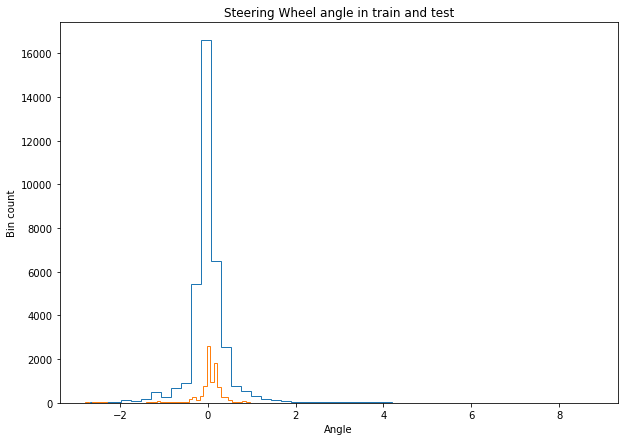

In [13]:
fig = plt.figure(figsize = (10, 7))
plt.hist(train_y, bins = 50, histtype = "step")
plt.hist(test_y, bins = 50, histtype = "step")
plt.title("Steering Wheel angle in train and test")
plt.xlabel("Angle")
plt.ylabel("Bin count")
plt.show()

In [14]:
def loadTrainBatch(batch_size):
    global train_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(train_x[(train_batch_pointer + i) % len(train_x)]) #here % len(train_x) is used to make sure that
        #"train_batch_pointer + i" should not cross the number of train images. As soon as the value of "train_batch_pointer" is
        #equal to number of train images then it will again start reading the train images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(train_y[(train_batch_pointer + i) % len(train_y)]) #appending corresponding labels
        
    train_batch_pointer += batch_size
        
    return x_result, y_result

In [15]:
def loadTestBatch(batch_size):
    global test_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(test_x[(test_batch_pointer + i) % len(test_x)]) #here % len(test_x) is used to make sure that
        #"test_batch_pointer + i" should not cross the number of test images. As soon as the value of "test_batch_pointer" is
        #equal to number of test images then it will again start reading the test images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(test_y[(test_batch_pointer + i) % len(test_y)]) #appending corresponding labels
        
    test_batch_pointer += batch_size
        
    return x_result, y_result

# MODEL ARCHITECTURE

In [16]:
def weightVariable(shape):
    initial = tf.truncated_normal(shape = shape, stddev = 0.1)
    return tf.Variable(initial) 

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def convolution(previous_input, filter_input, strides):
    return tf.nn.conv2d(previous_input, filter_input, strides = [1, strides, strides, 1], padding = "VALID")

In [17]:
x_input = tf.placeholder(tf.float32, shape = [None, 66, 200, 3], name = "Plc_1")
y_true = tf.placeholder(tf.float32, name = "Plc_2")

input_image = x_input

In [18]:
#Convolution Layers
#First convolution layer
W_Conv1 = weightVariable([5,5,3,24])
B_Conv1 = bias_variable([24])
Conv1 = tf.nn.relu(convolution(input_image, W_Conv1, 2) + B_Conv1)
#strides = 2
#Output size: 31*98*24

#Second convolution layer
W_Conv2 = weightVariable([5,5,24,36])
B_Conv2 = bias_variable([36])
Conv2 = tf.nn.relu(convolution(Conv1, W_Conv2, 2) + B_Conv2)
#strides = 2
#Output size: 14*47*36

#Third convolution layer
W_Conv3 = weightVariable([5,5,36,48])
B_Conv3 = bias_variable([48])
Conv3 = tf.nn.relu(convolution(Conv2, W_Conv3, 2) + B_Conv3)
#strides = 2
#Output size: 5*22*48

#Fourth convolution layer
W_Conv4 = weightVariable([3,3,48,64])
B_Conv4 = bias_variable([64])
Conv4 = tf.nn.relu(convolution(Conv3, W_Conv4, 1) + B_Conv4)
#strides = 1
#Output size: 3*20*64


#Fifth convolution layer
W_Conv5 = weightVariable([3,3,64,64])
B_Conv5 = bias_variable([64])
Conv5 = tf.nn.relu(convolution(Conv4, W_Conv5, 1) + B_Conv5)
#strides = 1
#Output size: 1*18*64

#Fully-Connected Dense Layers
keep_prob = tf.placeholder(tf.float32)
#First FC-Dense
#Input = 1*18*64 = 1152
W_FC1 = weightVariable([1152, 1164])
B_FC1 = bias_variable([1164])
FC1_Flatten = tf.reshape(Conv5, [-1, 1152]) #here, -1 indicates 1. It means that the shape of FC1_Flatten will be 1*1152
Output_FC1 = tf.nn.relu(tf.matmul(FC1_Flatten, W_FC1) + B_FC1) #so, here shape of FC1_Flatten is 1*1152 and shape of W_FC1 will
#be 1152*1164. Therefore, there will be a matrix multiplication of matrices: (1*1152) * (1152*1164) = (1*1164).
Output_FC1_drop = tf.nn.dropout(Output_FC1, keep_prob)

#Second FC-Dense
#Input = 1*1164 = 1164
W_FC2 = weightVariable([1164, 100])
B_FC2 = bias_variable([100])
Output_FC2 = tf.nn.relu(tf.matmul(Output_FC1_drop, W_FC2) + B_FC2) #so, here shape of Output_FC1_drop is 1*1164 and shape of 
#W_FC2 will be 1164*100. Therefore, there will be a matrix multiplication of matrices: (1*1164) * (1164*100) = (1*100).
Output_FC2_drop = tf.nn.dropout(Output_FC2, keep_prob)

#Third FC-Dense
#Input = 1*100 = 100
W_FC3 = weightVariable([100, 50])
B_FC3 = bias_variable([50])
Output_FC3 = tf.nn.relu(tf.matmul(Output_FC2_drop, W_FC3) + B_FC3) #so, here shape of Output_FC2_drop is 1*100 and shape of 
#W_FC3 will be 100*50. Therefore, there will be a matrix multiplication of matrices: (1*100) * (100*50) = (1*50).
Output_FC3_drop = tf.nn.dropout(Output_FC3, keep_prob)

#Fourth FC-Dense
#Input = 1*50 = 50
W_FC4 = weightVariable([50, 10])
B_FC4 = bias_variable([10])
Output_FC4 = tf.nn.relu(tf.matmul(Output_FC3_drop, W_FC4) + B_FC4) #so, here shape of Output_FC3_drop is 1*50 and shape of 
#W_FC4 will be 50*10. Therefore, there will be a matrix multiplication of matrices: (1*50) * (50*10) = (1*10).
Output_FC4_drop = tf.nn.dropout(Output_FC4, keep_prob)

#Final Output to one neuron with linear/identity function
#Input = 1*10 = 10
W_FC5 = weightVariable([10, 1])
B_FC5 = bias_variable([1])
y_predicted = tf.identity(tf.matmul(Output_FC4_drop, W_FC5) + B_FC5) #so, here shape of Output_FC4_drop is 1*10 and shape of 
#W_FC5 will be 10*1. Therefore, there will be a matrix multiplication of matrices: (1*10) * (10*1) = (1*1). Since, this is a 
#regression problem so we have applied identity fuction in the end. We can also apply "atan" function here. If computational
#power is available then the model should be tested with both identity and atan functions. In the end, that function should be
#considered which gives better result.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Training the model

In [17]:
pwd

'D:\\Study\\Applied_AI\\SELF_DRIVING_CAR\\Autopilot-TensorFlow-master'

In [18]:
SAVEDIR = "save_new"
sess = tf.InteractiveSession()

L2NormConst = 0.001
train_vars = tf.trainable_variables() #it will return all the variables. Here, all the weights and biases are variables which
#are trainable.

loss = tf.reduce_mean(tf.square(tf.subtract(y_true, y_predicted))) + tf.add_n([tf.nn.l2_loss(w) for w in train_vars]) * L2NormConst
#since this is a regression problem so above loss is mean-squared-error loss
# HYPERPARAMETER OPtimizer - Adam
train_step = tf.train.AdamOptimizer(learning_rate = 10**-4).minimize(loss)
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

epochs = 30
batch_size = 100
epoch_number, train_loss, test_loss,  = [], [], []

for epoch in range(epochs):
    train_avg_loss = 0
    test_avg_loss = 0
    te_loss_old = 10000  #any big number can be given
    
    for i in range(int(len(x)/batch_size)):
        train_batch_x, train_batch_y = loadTrainBatch(batch_size)
        train_step.run(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, keep_prob: 0.8})
        tr_loss = loss.eval(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, keep_prob: 1.0})
        train_avg_loss += tr_loss / batch_size
    
        test_batch_x, test_batch_y = loadTestBatch(batch_size)
        te_loss_new = loss.eval(feed_dict = {x_input: test_batch_x, y_true: test_batch_y, keep_prob: 1.0})
        test_avg_loss += te_loss_new / batch_size
        
        if te_loss_new < te_loss_old:
            print("Epoch: {}, Train_Loss: {}, Test_Loss: {} *".format(epoch+1, tr_loss, te_loss_new))
        else:
            print("Epoch: {}, Train_Loss: {}, Test_Loss: {}".format(epoch+1, tr_loss, te_loss_new))
        te_loss_old = te_loss_new
        
        if (i+1) % batch_size == 0:
            if not os.path.exists(SAVEDIR):
                os.makedirs(SAVEDIR)
            save_path = os.path.join(SAVEDIR, "model.ckpt")
            saver.save(sess = sess, save_path = save_path)
            print("Model saved at location {} at epoch {}".format(save_path, epoch + 1))
        
    epoch_number.append(epoch)
    train_loss.append(train_avg_loss)
    test_loss.append(test_avg_loss)
    
#creating dataframe and record all the losses and accuracies at each epoch
log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
log_frame["Epoch"] = epoch_number
log_frame["Train Loss"] = train_loss
log_frame["Test Loss"] = test_loss
log_frame.to_csv(os.path.join(SAVEDIR, "log.csv"), index = False)

Epoch: 1, Train_Loss: 6.931443214416504, Test_Loss: 6.679807662963867 *
Epoch: 1, Train_Loss: 6.5932488441467285, Test_Loss: 6.190629959106445 *
Epoch: 1, Train_Loss: 18.928695678710938, Test_Loss: 6.221070289611816
Epoch: 1, Train_Loss: 7.916269302368164, Test_Loss: 6.311333656311035
Epoch: 1, Train_Loss: 8.736098289489746, Test_Loss: 6.222428798675537 *
Epoch: 1, Train_Loss: 10.266275405883789, Test_Loss: 6.347701549530029
Epoch: 1, Train_Loss: 6.303419589996338, Test_Loss: 6.5708489418029785
Epoch: 1, Train_Loss: 6.311391353607178, Test_Loss: 7.498342037200928
Epoch: 1, Train_Loss: 7.192412376403809, Test_Loss: 8.01220703125
Epoch: 1, Train_Loss: 16.292089462280273, Test_Loss: 6.456736087799072 *
Epoch: 1, Train_Loss: 6.715980052947998, Test_Loss: 6.158851146697998 *
Epoch: 1, Train_Loss: 6.124484539031982, Test_Loss: 6.153463840484619 *
Epoch: 1, Train_Loss: 10.860284805297852, Test_Loss: 6.158249378204346
Epoch: 1, Train_Loss: 7.203709602355957, Test_Loss: 6.146958827972412 *
Epoc

Epoch: 1, Train_Loss: 5.5383806228637695, Test_Loss: 5.53547477722168 *
Epoch: 1, Train_Loss: 5.645219326019287, Test_Loss: 5.530805587768555 *
Epoch: 1, Train_Loss: 5.649725437164307, Test_Loss: 5.573405742645264
Epoch: 1, Train_Loss: 5.653114318847656, Test_Loss: 10.947040557861328
Epoch: 1, Train_Loss: 5.601764678955078, Test_Loss: 5.754220485687256 *
Epoch: 1, Train_Loss: 5.508520603179932, Test_Loss: 5.5194268226623535 *
Epoch: 1, Train_Loss: 5.6166276931762695, Test_Loss: 5.5073065757751465 *
Epoch: 1, Train_Loss: 5.675382137298584, Test_Loss: 5.50648832321167 *
Epoch: 1, Train_Loss: 5.655325412750244, Test_Loss: 5.501992702484131 *
Epoch: 1, Train_Loss: 5.62756872177124, Test_Loss: 5.49200439453125 *
Epoch: 1, Train_Loss: 5.491737365722656, Test_Loss: 5.492900371551514
Epoch: 1, Train_Loss: 5.481453895568848, Test_Loss: 5.48583984375 *
Epoch: 1, Train_Loss: 5.476634502410889, Test_Loss: 5.480947017669678 *
Epoch: 1, Train_Loss: 5.468019485473633, Test_Loss: 5.478050708770752 *
E

Epoch: 1, Train_Loss: 4.982192039489746, Test_Loss: 4.979316234588623 *
Epoch: 1, Train_Loss: 4.973635196685791, Test_Loss: 4.972950458526611 *
Epoch: 1, Train_Loss: 4.98661470413208, Test_Loss: 4.970463752746582 *
Epoch: 1, Train_Loss: 4.9854512214660645, Test_Loss: 4.965851783752441 *
Epoch: 1, Train_Loss: 4.982999801635742, Test_Loss: 4.960963726043701 *
Epoch: 1, Train_Loss: 4.95667028427124, Test_Loss: 4.956366539001465 *
Epoch: 1, Train_Loss: 5.019588947296143, Test_Loss: 4.9518022537231445 *
Epoch: 1, Train_Loss: 5.006982803344727, Test_Loss: 4.946010589599609 *
Epoch: 1, Train_Loss: 4.982626438140869, Test_Loss: 4.942715644836426 *
Epoch: 1, Train_Loss: 4.940338134765625, Test_Loss: 4.9466352462768555
Epoch: 1, Train_Loss: 4.955842018127441, Test_Loss: 4.990040302276611
Epoch: 1, Train_Loss: 4.929582118988037, Test_Loss: 7.487386226654053
Epoch: 1, Train_Loss: 4.943796634674072, Test_Loss: 7.9872846603393555
Epoch: 1, Train_Loss: 4.928334712982178, Test_Loss: 4.924557685852051 

Epoch: 1, Train_Loss: 4.8135151863098145, Test_Loss: 4.505256652832031 *
Epoch: 1, Train_Loss: 6.60598087310791, Test_Loss: 4.49284553527832 *
Epoch: 1, Train_Loss: 5.006101608276367, Test_Loss: 4.577648162841797
Epoch: 1, Train_Loss: 5.428182125091553, Test_Loss: 4.530070781707764 *
Epoch: 1, Train_Loss: 4.503808975219727, Test_Loss: 4.6012091636657715
Epoch: 1, Train_Loss: 4.475434303283691, Test_Loss: 4.579659461975098 *
Epoch: 1, Train_Loss: 4.859423637390137, Test_Loss: 4.48668098449707 *
Epoch: 1, Train_Loss: 5.887051582336426, Test_Loss: 4.474666118621826 *
Epoch: 1, Train_Loss: 4.769997596740723, Test_Loss: 4.4713287353515625 *
Epoch: 1, Train_Loss: 4.584727764129639, Test_Loss: 4.4628143310546875 *
Epoch: 1, Train_Loss: 4.456618785858154, Test_Loss: 4.461325645446777 *
Epoch: 1, Train_Loss: 4.566864490509033, Test_Loss: 4.4587297439575195 *
Epoch: 1, Train_Loss: 4.789705276489258, Test_Loss: 4.453181266784668 *
Epoch: 1, Train_Loss: 4.767153739929199, Test_Loss: 4.445653438568

Epoch: 2, Train_Loss: 4.101891040802002, Test_Loss: 4.1461334228515625 *
Epoch: 2, Train_Loss: 4.1714186668396, Test_Loss: 4.093815326690674 *
Epoch: 2, Train_Loss: 4.154326915740967, Test_Loss: 4.0876784324646 *
Epoch: 2, Train_Loss: 4.105301380157471, Test_Loss: 4.1978044509887695
Epoch: 2, Train_Loss: 4.154993534088135, Test_Loss: 4.887609958648682
Epoch: 2, Train_Loss: 4.092782497406006, Test_Loss: 5.668546199798584
Epoch: 2, Train_Loss: 4.07569694519043, Test_Loss: 4.424839496612549 *
Epoch: 2, Train_Loss: 4.062168598175049, Test_Loss: 4.132983684539795 *
Epoch: 2, Train_Loss: 4.0580668449401855, Test_Loss: 4.053072929382324 *
Epoch: 2, Train_Loss: 4.054207801818848, Test_Loss: 4.062377452850342
Epoch: 2, Train_Loss: 4.051242828369141, Test_Loss: 4.054753303527832 *
Epoch: 2, Train_Loss: 4.045616626739502, Test_Loss: 4.057008266448975
Epoch: 2, Train_Loss: 8.571471214294434, Test_Loss: 4.105648994445801
Epoch: 2, Train_Loss: 4.574383735656738, Test_Loss: 4.106281757354736
Epoch: 2

Epoch: 2, Train_Loss: 3.7188665866851807, Test_Loss: 3.721297264099121
Epoch: 2, Train_Loss: 3.716754674911499, Test_Loss: 8.864075660705566
Epoch: 2, Train_Loss: 3.789020299911499, Test_Loss: 4.187892913818359 *
Epoch: 2, Train_Loss: 3.704362630844116, Test_Loss: 3.704685688018799 *
Epoch: 2, Train_Loss: 3.7940027713775635, Test_Loss: 3.6948204040527344 *
Epoch: 2, Train_Loss: 3.700807571411133, Test_Loss: 3.693056583404541 *
Epoch: 2, Train_Loss: 3.7166030406951904, Test_Loss: 3.6938438415527344
Epoch: 2, Train_Loss: 3.7188117504119873, Test_Loss: 3.6869752407073975 *
Epoch: 2, Train_Loss: 3.958653211593628, Test_Loss: 3.68892765045166
Epoch: 2, Train_Loss: 3.6900668144226074, Test_Loss: 3.6831657886505127 *
Epoch: 2, Train_Loss: 3.7022712230682373, Test_Loss: 3.680928945541382 *
Epoch: 2, Train_Loss: 3.6741998195648193, Test_Loss: 3.6804230213165283 *
Epoch: 2, Train_Loss: 3.6722259521484375, Test_Loss: 3.6801908016204834 *
Epoch: 2, Train_Loss: 3.6703197956085205, Test_Loss: 3.6745

Epoch: 2, Train_Loss: 3.4476828575134277, Test_Loss: 3.379822254180908 *
Epoch: 2, Train_Loss: 3.740043878555298, Test_Loss: 3.3803505897521973
Epoch: 2, Train_Loss: 3.418680191040039, Test_Loss: 3.378939390182495 *
Epoch: 2, Train_Loss: 3.4804365634918213, Test_Loss: 3.375203847885132 *
Epoch: 2, Train_Loss: 3.591430902481079, Test_Loss: 3.3707969188690186 *
Epoch: 2, Train_Loss: 3.5793373584747314, Test_Loss: 3.3690996170043945 *
Epoch: 2, Train_Loss: 3.388547897338867, Test_Loss: 3.3652186393737793 *
Epoch: 2, Train_Loss: 3.3914949893951416, Test_Loss: 3.3637797832489014 *
Epoch: 2, Train_Loss: 3.3632216453552246, Test_Loss: 3.368835687637329
Epoch: 2, Train_Loss: 3.390892267227173, Test_Loss: 3.4156692028045654
Epoch: 2, Train_Loss: 3.5096023082733154, Test_Loss: 5.228188514709473
Epoch: 2, Train_Loss: 3.992682456970215, Test_Loss: 6.83483362197876
Epoch: 2, Train_Loss: 3.6177022457122803, Test_Loss: 3.349370241165161 *
Epoch: 2, Train_Loss: 4.198832035064697, Test_Loss: 3.34297108

Epoch: 2, Train_Loss: 3.114222526550293, Test_Loss: 3.1146721839904785 *
Epoch: 2, Train_Loss: 3.118837833404541, Test_Loss: 3.115180015563965
Epoch: 2, Train_Loss: 3.121002435684204, Test_Loss: 3.153829574584961
Epoch: 2, Train_Loss: 3.113842010498047, Test_Loss: 3.139803409576416 *
Epoch: 2, Train_Loss: 3.1013007164001465, Test_Loss: 3.238271474838257
Epoch: 2, Train_Loss: 3.0989975929260254, Test_Loss: 3.2510547637939453
Epoch: 2, Train_Loss: 3.100302219390869, Test_Loss: 3.0939276218414307 *
Epoch: 2, Train_Loss: 3.1091091632843018, Test_Loss: 3.086738348007202 *
Epoch: 2, Train_Loss: 3.093245267868042, Test_Loss: 3.0809226036071777 *
Epoch: 2, Train_Loss: 3.0876665115356445, Test_Loss: 3.0773839950561523 *
Epoch: 2, Train_Loss: 3.0847675800323486, Test_Loss: 3.0754570960998535 *
Epoch: 2, Train_Loss: 3.0986344814300537, Test_Loss: 3.073528289794922 *
Epoch: 2, Train_Loss: 3.079390048980713, Test_Loss: 3.0710408687591553 *
Epoch: 2, Train_Loss: 3.073795795440674, Test_Loss: 3.06831

Epoch: 3, Train_Loss: 2.8470523357391357, Test_Loss: 3.2158546447753906 *
Epoch: 3, Train_Loss: 2.8444552421569824, Test_Loss: 2.955400228500366 *
Epoch: 3, Train_Loss: 2.855131149291992, Test_Loss: 2.8766942024230957 *
Epoch: 3, Train_Loss: 2.849830150604248, Test_Loss: 2.853146553039551 *
Epoch: 3, Train_Loss: 2.838733434677124, Test_Loss: 2.9149863719940186
Epoch: 3, Train_Loss: 2.836557626724243, Test_Loss: 3.4321961402893066
Epoch: 3, Train_Loss: 2.841890335083008, Test_Loss: 4.269993305206299
Epoch: 3, Train_Loss: 2.928969144821167, Test_Loss: 3.2825305461883545 *
Epoch: 3, Train_Loss: 2.8525924682617188, Test_Loss: 2.929119110107422 *
Epoch: 3, Train_Loss: 2.8686811923980713, Test_Loss: 2.834641218185425 *
Epoch: 3, Train_Loss: 2.8270421028137207, Test_Loss: 2.833867311477661 *
Epoch: 3, Train_Loss: 2.8418333530426025, Test_Loss: 2.827814817428589 *
Epoch: 3, Train_Loss: 2.8641090393066406, Test_Loss: 2.831967830657959
Epoch: 3, Train_Loss: 2.8211874961853027, Test_Loss: 2.86070

Epoch: 3, Train_Loss: 3.061316728591919, Test_Loss: 2.641331672668457 *
Epoch: 3, Train_Loss: 2.626039743423462, Test_Loss: 2.638814926147461 *
Epoch: 3, Train_Loss: 2.6491739749908447, Test_Loss: 2.651198387145996
Epoch: 3, Train_Loss: 2.8586266040802, Test_Loss: 7.104144096374512
Epoch: 3, Train_Loss: 3.14123272895813, Test_Loss: 3.59574294090271 *
Epoch: 3, Train_Loss: 2.830264091491699, Test_Loss: 2.618483781814575 *
Epoch: 3, Train_Loss: 2.612889051437378, Test_Loss: 2.611654758453369 *
Epoch: 3, Train_Loss: 2.8837993144989014, Test_Loss: 2.609264373779297 *
Epoch: 3, Train_Loss: 3.227222442626953, Test_Loss: 2.613096237182617
Epoch: 3, Train_Loss: 3.0801453590393066, Test_Loss: 2.607771873474121 *
Epoch: 3, Train_Loss: 2.6353516578674316, Test_Loss: 2.614748239517212
Epoch: 3, Train_Loss: 2.6142656803131104, Test_Loss: 2.6066973209381104 *
Epoch: 3, Train_Loss: 2.6403238773345947, Test_Loss: 2.6084418296813965
Epoch: 3, Train_Loss: 3.866658926010132, Test_Loss: 2.609251022338867


Epoch: 3, Train_Loss: 2.4335508346557617, Test_Loss: 2.4349589347839355 *
Epoch: 3, Train_Loss: 2.4334542751312256, Test_Loss: 2.4395053386688232
Epoch: 3, Train_Loss: 2.448383331298828, Test_Loss: 2.4318156242370605 *
Epoch: 3, Train_Loss: 2.4686038494110107, Test_Loss: 2.434278964996338
Epoch: 3, Train_Loss: 2.4382519721984863, Test_Loss: 2.436457872390747
Epoch: 3, Train_Loss: 2.4351518154144287, Test_Loss: 2.432281255722046 *
Epoch: 3, Train_Loss: 2.6314287185668945, Test_Loss: 2.4291832447052 *
Epoch: 3, Train_Loss: 2.61942720413208, Test_Loss: 2.4295573234558105
Epoch: 3, Train_Loss: 2.543729782104492, Test_Loss: 2.4257590770721436 *
Epoch: 3, Train_Loss: 2.445669174194336, Test_Loss: 2.4260764122009277
Epoch: 3, Train_Loss: 2.539857864379883, Test_Loss: 2.4320051670074463
Epoch: 3, Train_Loss: 2.5185110569000244, Test_Loss: 2.4769790172576904
Epoch: 3, Train_Loss: 2.564500331878662, Test_Loss: 3.711503744125366
Epoch: 3, Train_Loss: 2.54567289352417, Test_Loss: 6.88027286529541


Epoch: 3, Train_Loss: 2.265209436416626, Test_Loss: 2.296295642852783 *
Epoch: 3, Train_Loss: 2.2729055881500244, Test_Loss: 2.2710347175598145 *
Epoch: 3, Train_Loss: 2.264381170272827, Test_Loss: 2.2769315242767334
Epoch: 3, Train_Loss: 2.260406255722046, Test_Loss: 2.318798780441284
Epoch: 3, Train_Loss: 2.294583797454834, Test_Loss: 2.3255221843719482
Epoch: 3, Train_Loss: 2.345966339111328, Test_Loss: 2.369379758834839
Epoch: 3, Train_Loss: 2.3333933353424072, Test_Loss: 2.4244494438171387
Epoch: 3, Train_Loss: 2.2527859210968018, Test_Loss: 2.2621495723724365 *
Epoch: 3, Train_Loss: 2.2533578872680664, Test_Loss: 2.263068437576294
Epoch: 3, Train_Loss: 2.251055955886841, Test_Loss: 2.2543253898620605 *
Epoch: 3, Train_Loss: 2.2499043941497803, Test_Loss: 2.251180648803711 *
Epoch: 3, Train_Loss: 2.248640537261963, Test_Loss: 2.249847650527954 *
Epoch: 3, Train_Loss: 2.245997667312622, Test_Loss: 2.24845027923584 *
Epoch: 3, Train_Loss: 2.242955207824707, Test_Loss: 2.247081995010

Epoch: 4, Train_Loss: 2.136301040649414, Test_Loss: 2.635755777359009
Epoch: 4, Train_Loss: 2.233294725418091, Test_Loss: 2.503710985183716 *
Epoch: 4, Train_Loss: 2.1924517154693604, Test_Loss: 2.211167097091675 *
Epoch: 4, Train_Loss: 2.275733232498169, Test_Loss: 2.1099281311035156 *
Epoch: 4, Train_Loss: 2.5451154708862305, Test_Loss: 2.1220450401306152
Epoch: 4, Train_Loss: 2.2224483489990234, Test_Loss: 2.1489179134368896
Epoch: 4, Train_Loss: 2.1694247722625732, Test_Loss: 2.5163044929504395
Epoch: 4, Train_Loss: 2.3048200607299805, Test_Loss: 3.3419578075408936
Epoch: 4, Train_Loss: 2.3538949489593506, Test_Loss: 2.678896427154541 *
Epoch: 4, Train_Loss: 2.3301808834075928, Test_Loss: 2.1357109546661377 *
Epoch: 4, Train_Loss: 2.155473232269287, Test_Loss: 2.1226584911346436 *
Epoch: 4, Train_Loss: 2.247326612472534, Test_Loss: 2.1529994010925293
Epoch: 4, Train_Loss: 2.334362268447876, Test_Loss: 2.1612346172332764
Epoch: 4, Train_Loss: 2.146552801132202, Test_Loss: 2.18385028

Epoch: 4, Train_Loss: 1.9750542640686035, Test_Loss: 1.9696027040481567 *
Epoch: 4, Train_Loss: 1.9931682348251343, Test_Loss: 1.9684571027755737 *
Epoch: 4, Train_Loss: 2.021427631378174, Test_Loss: 1.9751145839691162
Epoch: 4, Train_Loss: 1.9981926679611206, Test_Loss: 5.976499080657959
Epoch: 4, Train_Loss: 1.9732354879379272, Test_Loss: 3.7684671878814697 *
Epoch: 4, Train_Loss: 1.9690942764282227, Test_Loss: 1.9854031801223755 *
Epoch: 4, Train_Loss: 1.9645811319351196, Test_Loss: 1.9739339351654053 *
Epoch: 4, Train_Loss: 1.9610698223114014, Test_Loss: 1.9733790159225464 *
Epoch: 4, Train_Loss: 1.9614466428756714, Test_Loss: 1.9643206596374512 *
Epoch: 4, Train_Loss: 1.9610087871551514, Test_Loss: 1.9664883613586426
Epoch: 4, Train_Loss: 1.963388204574585, Test_Loss: 1.9733844995498657
Epoch: 4, Train_Loss: 1.9590883255004883, Test_Loss: 1.9631437063217163 *
Epoch: 4, Train_Loss: 1.9567800760269165, Test_Loss: 1.9652904272079468
Epoch: 4, Train_Loss: 1.9558913707733154, Test_Loss

Epoch: 4, Train_Loss: 2.014763593673706, Test_Loss: 1.8541933298110962 *
Epoch: 4, Train_Loss: 1.911895513534546, Test_Loss: 1.8594087362289429
Epoch: 4, Train_Loss: 2.026811361312866, Test_Loss: 1.852895975112915 *
Epoch: 4, Train_Loss: 1.9748902320861816, Test_Loss: 1.8568205833435059
Epoch: 4, Train_Loss: 1.9563642740249634, Test_Loss: 1.860227108001709
Epoch: 4, Train_Loss: 1.9956849813461304, Test_Loss: 1.8528821468353271 *
Epoch: 4, Train_Loss: 2.1939892768859863, Test_Loss: 1.851060152053833 *
Epoch: 4, Train_Loss: 1.8604353666305542, Test_Loss: 1.8519618511199951
Epoch: 4, Train_Loss: 1.8658846616744995, Test_Loss: 1.849025011062622 *
Epoch: 4, Train_Loss: 4.479223251342773, Test_Loss: 1.8489010334014893 *
Epoch: 4, Train_Loss: 2.5941431522369385, Test_Loss: 1.8523077964782715
Epoch: 4, Train_Loss: 1.8652845621109009, Test_Loss: 1.9044520854949951
Epoch: 4, Train_Loss: 1.87956964969635, Test_Loss: 2.445075511932373
Epoch: 4, Train_Loss: 1.8835971355438232, Test_Loss: 6.91583442

Epoch: 4, Train_Loss: 1.8038533926010132, Test_Loss: 1.7589991092681885
Epoch: 4, Train_Loss: 1.7576247453689575, Test_Loss: 1.778749704360962
Epoch: 4, Train_Loss: 1.7413098812103271, Test_Loss: 1.7499526739120483 *
Epoch: 4, Train_Loss: 1.8219435214996338, Test_Loss: 1.7532916069030762
Epoch: 4, Train_Loss: 1.7554904222488403, Test_Loss: 1.8030046224594116
Epoch: 4, Train_Loss: 1.7519679069519043, Test_Loss: 1.8331341743469238
Epoch: 4, Train_Loss: 2.238393545150757, Test_Loss: 1.8189432621002197 *
Epoch: 4, Train_Loss: 3.2039928436279297, Test_Loss: 1.8660805225372314
Epoch: 4, Train_Loss: 2.7425310611724854, Test_Loss: 1.7534599304199219 *
Epoch: 4, Train_Loss: 1.8790428638458252, Test_Loss: 1.7683945894241333
Epoch: 4, Train_Loss: 2.021089792251587, Test_Loss: 1.7559213638305664 *
Epoch: 4, Train_Loss: 4.109771251678467, Test_Loss: 1.7515984773635864 *
Epoch: 4, Train_Loss: 2.581252098083496, Test_Loss: 1.7513436079025269 *
Epoch: 4, Train_Loss: 1.7775198221206665, Test_Loss: 1.75

Epoch: 5, Train_Loss: 1.6792988777160645, Test_Loss: 1.7312129735946655 *
Epoch: 5, Train_Loss: 1.6767290830612183, Test_Loss: 1.877880573272705
Epoch: 5, Train_Loss: 6.662769794464111, Test_Loss: 1.9002004861831665
Epoch: 5, Train_Loss: 13.651662826538086, Test_Loss: 1.7273069620132446 *
Epoch: 5, Train_Loss: 2.1770710945129395, Test_Loss: 1.646237850189209 *
Epoch: 5, Train_Loss: 4.499354839324951, Test_Loss: 1.6690289974212646
Epoch: 5, Train_Loss: 2.1105434894561768, Test_Loss: 1.6534886360168457 *
Epoch: 5, Train_Loss: 1.7209786176681519, Test_Loss: 1.7806297540664673
Epoch: 5, Train_Loss: 1.741137146949768, Test_Loss: 2.2799196243286133
Epoch: 5, Train_Loss: 10.814035415649414, Test_Loss: 2.037412405014038 *
Epoch: 5, Train_Loss: 3.5891427993774414, Test_Loss: 1.702134132385254 *
Epoch: 5, Train_Loss: 1.699114441871643, Test_Loss: 1.6849168539047241 *
Epoch: 5, Train_Loss: 3.866565704345703, Test_Loss: 1.7554361820220947
Epoch: 5, Train_Loss: 5.347507953643799, Test_Loss: 1.78062

Epoch: 5, Train_Loss: 1.5545282363891602, Test_Loss: 1.5534369945526123 *
Epoch: 5, Train_Loss: 1.553135871887207, Test_Loss: 1.5524001121520996 *
Epoch: 5, Train_Loss: 1.5512847900390625, Test_Loss: 1.5517120361328125 *
Epoch: 5, Train_Loss: 1.627807855606079, Test_Loss: 1.5509467124938965 *
Epoch: 5, Train_Loss: 1.6769264936447144, Test_Loss: 1.555158019065857
Epoch: 5, Train_Loss: 1.6852269172668457, Test_Loss: 4.6529059410095215
Epoch: 5, Train_Loss: 1.6756548881530762, Test_Loss: 4.14491081237793 *
Epoch: 5, Train_Loss: 1.5491899251937866, Test_Loss: 1.552704095840454 *
Epoch: 5, Train_Loss: 1.595977783203125, Test_Loss: 1.5470659732818604 *
Epoch: 5, Train_Loss: 1.7162736654281616, Test_Loss: 1.5445963144302368 *
Epoch: 5, Train_Loss: 1.7068334817886353, Test_Loss: 1.5474516153335571
Epoch: 5, Train_Loss: 1.7197102308273315, Test_Loss: 1.5445019006729126 *
Epoch: 5, Train_Loss: 1.551375389099121, Test_Loss: 1.5482443571090698
Epoch: 5, Train_Loss: 1.5419713258743286, Test_Loss: 1

Epoch: 5, Train_Loss: 1.5036213397979736, Test_Loss: 1.4684944152832031 *
Epoch: 5, Train_Loss: 1.4944939613342285, Test_Loss: 1.4720052480697632
Epoch: 5, Train_Loss: 1.495813012123108, Test_Loss: 1.4690762758255005 *
Epoch: 5, Train_Loss: 1.489456057548523, Test_Loss: 1.4668205976486206 *
Epoch: 5, Train_Loss: 1.4710863828659058, Test_Loss: 1.470099925994873
Epoch: 5, Train_Loss: 1.4654284715652466, Test_Loss: 1.4641900062561035 *
Epoch: 5, Train_Loss: 1.4773322343826294, Test_Loss: 1.4653326272964478
Epoch: 5, Train_Loss: 1.478757619857788, Test_Loss: 1.4687379598617554
Epoch: 5, Train_Loss: 1.4887163639068604, Test_Loss: 1.4656041860580444 *
Epoch: 5, Train_Loss: 1.4614289999008179, Test_Loss: 1.464977741241455 *
Epoch: 5, Train_Loss: 1.5247368812561035, Test_Loss: 1.463118553161621 *
Epoch: 5, Train_Loss: 1.533786654472351, Test_Loss: 1.462929606437683 *
Epoch: 5, Train_Loss: 1.5159800052642822, Test_Loss: 1.4625244140625 *
Epoch: 5, Train_Loss: 1.4587311744689941, Test_Loss: 1.46

Epoch: 5, Train_Loss: 1.404109001159668, Test_Loss: 1.4008357524871826 *
Epoch: 5, Train_Loss: 1.3973499536514282, Test_Loss: 1.4547792673110962
Epoch: 5, Train_Loss: 1.430747151374817, Test_Loss: 1.4043587446212769 *
Epoch: 5, Train_Loss: 1.5309700965881348, Test_Loss: 1.397297978401184 *
Epoch: 5, Train_Loss: 2.122018337249756, Test_Loss: 1.4081859588623047
Epoch: 5, Train_Loss: 1.5725886821746826, Test_Loss: 1.4489021301269531
Epoch: 5, Train_Loss: 3.3744444847106934, Test_Loss: 1.391403317451477 *
Epoch: 5, Train_Loss: 1.982861042022705, Test_Loss: 1.4469903707504272
Epoch: 5, Train_Loss: 2.40432071685791, Test_Loss: 1.4364756345748901 *
Epoch: 5, Train_Loss: 1.5089573860168457, Test_Loss: 1.4379549026489258
Epoch: 5, Train_Loss: 1.3923298120498657, Test_Loss: 1.431817889213562 *
Epoch: 5, Train_Loss: 1.5367088317871094, Test_Loss: 1.4173500537872314 *
Epoch: 5, Train_Loss: 2.568769931793213, Test_Loss: 1.4108161926269531 *
Epoch: 5, Train_Loss: 2.086381435394287, Test_Loss: 1.3807

Epoch: 5, Train_Loss: 1.3213962316513062, Test_Loss: 1.3367161750793457
Epoch: 5, Train_Loss: 1.3243318796157837, Test_Loss: 1.3216018676757812 *
Epoch: 5, Train_Loss: 1.3535990715026855, Test_Loss: 1.3402891159057617
Epoch: 6, Train_Loss: 1.3858228921890259, Test_Loss: 1.341217279434204 *
Epoch: 6, Train_Loss: 1.3513442277908325, Test_Loss: 1.6936979293823242
Epoch: 6, Train_Loss: 1.356937050819397, Test_Loss: 1.6781388521194458 *
Epoch: 6, Train_Loss: 1.3577419519424438, Test_Loss: 1.40636146068573 *
Epoch: 6, Train_Loss: 1.4019067287445068, Test_Loss: 1.3223633766174316 *
Epoch: 6, Train_Loss: 1.371917486190796, Test_Loss: 1.3325821161270142
Epoch: 6, Train_Loss: 1.3730512857437134, Test_Loss: 1.3590532541275024
Epoch: 6, Train_Loss: 1.4502873420715332, Test_Loss: 1.5457671880722046
Epoch: 6, Train_Loss: 1.356346607208252, Test_Loss: 2.446218490600586
Epoch: 6, Train_Loss: 1.337014079093933, Test_Loss: 2.0163772106170654 *
Epoch: 6, Train_Loss: 1.314887285232544, Test_Loss: 1.357257

Epoch: 6, Train_Loss: 1.3675280809402466, Test_Loss: 1.4069069623947144
Epoch: 6, Train_Loss: 1.3476144075393677, Test_Loss: 1.5510470867156982
Epoch: 6, Train_Loss: 1.2983176708221436, Test_Loss: 1.4427552223205566 *
Epoch: 6, Train_Loss: 1.2527084350585938, Test_Loss: 1.2565046548843384 *
Epoch: 6, Train_Loss: 1.2833302021026611, Test_Loss: 1.2530368566513062 *
Epoch: 6, Train_Loss: 1.2507822513580322, Test_Loss: 1.252454161643982 *
Epoch: 6, Train_Loss: 1.260404109954834, Test_Loss: 1.251832365989685 *
Epoch: 6, Train_Loss: 1.2550925016403198, Test_Loss: 1.2596466541290283
Epoch: 6, Train_Loss: 1.2564440965652466, Test_Loss: 3.4694623947143555
Epoch: 6, Train_Loss: 1.323449730873108, Test_Loss: 4.605767250061035
Epoch: 6, Train_Loss: 1.2591623067855835, Test_Loss: 1.2553796768188477 *
Epoch: 6, Train_Loss: 1.335556149482727, Test_Loss: 1.2478753328323364 *
Epoch: 6, Train_Loss: 1.253861427307129, Test_Loss: 1.2454792261123657 *
Epoch: 6, Train_Loss: 1.2674590349197388, Test_Loss: 1.

Epoch: 6, Train_Loss: 1.1945340633392334, Test_Loss: 1.1975280046463013
Epoch: 6, Train_Loss: 1.3516584634780884, Test_Loss: 1.21467924118042
Epoch: 6, Train_Loss: 1.4887380599975586, Test_Loss: 1.1942716836929321 *
Epoch: 6, Train_Loss: 1.1930811405181885, Test_Loss: 1.2179425954818726
Epoch: 6, Train_Loss: 1.5491771697998047, Test_Loss: 1.206298589706421 *
Epoch: 6, Train_Loss: 1.217646598815918, Test_Loss: 1.210693359375
Epoch: 6, Train_Loss: 1.201236605644226, Test_Loss: 1.1964571475982666 *
Epoch: 6, Train_Loss: 1.235966682434082, Test_Loss: 1.210679531097412
Epoch: 6, Train_Loss: 1.3790132999420166, Test_Loss: 1.2216094732284546
Epoch: 6, Train_Loss: 1.2536134719848633, Test_Loss: 1.23726224899292
Epoch: 6, Train_Loss: 1.2532601356506348, Test_Loss: 1.2235004901885986 *
Epoch: 6, Train_Loss: 1.2004356384277344, Test_Loss: 1.210255742073059 *
Epoch: 6, Train_Loss: 1.308319330215454, Test_Loss: 1.1958814859390259 *
Epoch: 6, Train_Loss: 1.2132422924041748, Test_Loss: 1.208215594291

Epoch: 6, Train_Loss: 1.1927001476287842, Test_Loss: 1.1501948833465576 *
Epoch: 6, Train_Loss: 1.1526058912277222, Test_Loss: 1.168060064315796
Epoch: 6, Train_Loss: 1.135626196861267, Test_Loss: 1.1423288583755493 *
Epoch: 6, Train_Loss: 1.1441062688827515, Test_Loss: 1.2761645317077637
Epoch: 6, Train_Loss: 1.1453434228897095, Test_Loss: 1.1710495948791504 *
Epoch: 6, Train_Loss: 2.738419532775879, Test_Loss: 1.131859302520752 *
Epoch: 6, Train_Loss: 5.132850170135498, Test_Loss: 1.1814254522323608
Epoch: 6, Train_Loss: 1.1345118284225464, Test_Loss: 1.139390468597412 *
Epoch: 6, Train_Loss: 1.171708345413208, Test_Loss: 1.1444131135940552
Epoch: 6, Train_Loss: 1.1592141389846802, Test_Loss: 1.1678919792175293
Epoch: 6, Train_Loss: 1.1429756879806519, Test_Loss: 1.1666479110717773 *
Epoch: 6, Train_Loss: 1.134647250175476, Test_Loss: 1.2020922899246216
Epoch: 6, Train_Loss: 1.1352403163909912, Test_Loss: 1.2644919157028198
Epoch: 6, Train_Loss: 1.1419285535812378, Test_Loss: 1.17166

Epoch: 6, Train_Loss: 1.0813865661621094, Test_Loss: 1.0967329740524292 *
Epoch: 6, Train_Loss: 1.0858784914016724, Test_Loss: 1.0981700420379639
Epoch: 6, Train_Loss: 1.0904288291931152, Test_Loss: 1.0817997455596924 *
Epoch: 6, Train_Loss: 1.0945671796798706, Test_Loss: 1.100064992904663
Epoch: 6, Train_Loss: 1.0943959951400757, Test_Loss: 1.1443841457366943
Epoch: 7, Train_Loss: 1.0860830545425415, Test_Loss: 1.086343765258789 *
Epoch: 7, Train_Loss: 1.0875775814056396, Test_Loss: 1.552469253540039
Epoch: 7, Train_Loss: 1.0773155689239502, Test_Loss: 1.624284267425537
Epoch: 7, Train_Loss: 1.0761011838912964, Test_Loss: 1.2474300861358643 *
Epoch: 7, Train_Loss: 1.0928648710250854, Test_Loss: 1.1050852537155151 *
Epoch: 7, Train_Loss: 1.0995162725448608, Test_Loss: 1.0996482372283936 *
Epoch: 7, Train_Loss: 1.0746952295303345, Test_Loss: 1.0939780473709106 *
Epoch: 7, Train_Loss: 1.075211524963379, Test_Loss: 1.2492451667785645
Epoch: 7, Train_Loss: 1.0740911960601807, Test_Loss: 2.

Epoch: 7, Train_Loss: 1.0358209609985352, Test_Loss: 1.038872241973877 *
Epoch: 7, Train_Loss: 1.0314714908599854, Test_Loss: 1.0875914096832275
Epoch: 7, Train_Loss: 1.0398712158203125, Test_Loss: 1.151273250579834
Epoch: 7, Train_Loss: 1.0964853763580322, Test_Loss: 1.4235583543777466
Epoch: 7, Train_Loss: 1.0529797077178955, Test_Loss: 1.3344281911849976 *
Epoch: 7, Train_Loss: 1.1060420274734497, Test_Loss: 1.054918885231018 *
Epoch: 7, Train_Loss: 1.1639324426651, Test_Loss: 1.0320781469345093 *
Epoch: 7, Train_Loss: 1.42704176902771, Test_Loss: 1.0304625034332275 *
Epoch: 7, Train_Loss: 1.0319241285324097, Test_Loss: 1.0291249752044678 *
Epoch: 7, Train_Loss: 1.074942708015442, Test_Loss: 1.0584584474563599
Epoch: 7, Train_Loss: 1.1620899438858032, Test_Loss: 2.529116153717041
Epoch: 7, Train_Loss: 1.5194220542907715, Test_Loss: 5.057735919952393
Epoch: 7, Train_Loss: 1.28639817237854, Test_Loss: 1.0456777811050415 *
Epoch: 7, Train_Loss: 1.0465492010116577, Test_Loss: 1.03649854

Epoch: 7, Train_Loss: 1.0000449419021606, Test_Loss: 1.0944855213165283
Epoch: 7, Train_Loss: 1.0073330402374268, Test_Loss: 1.0147085189819336 *
Epoch: 7, Train_Loss: 1.017907738685608, Test_Loss: 1.0667418241500854
Epoch: 7, Train_Loss: 0.9919539093971252, Test_Loss: 1.0615113973617554 *
Epoch: 7, Train_Loss: 1.0348058938980103, Test_Loss: 1.0006057024002075 *
Epoch: 7, Train_Loss: 9.672167778015137, Test_Loss: 1.0725696086883545
Epoch: 7, Train_Loss: 1.0652703046798706, Test_Loss: 1.0759060382843018
Epoch: 7, Train_Loss: 1.0119003057479858, Test_Loss: 1.124913215637207
Epoch: 7, Train_Loss: 1.080956220626831, Test_Loss: 1.0713003873825073 *
Epoch: 7, Train_Loss: 1.088847279548645, Test_Loss: 1.08686101436615
Epoch: 7, Train_Loss: 0.9949418306350708, Test_Loss: 1.1681970357894897
Epoch: 7, Train_Loss: 1.0277708768844604, Test_Loss: 1.235650658607483
Epoch: 7, Train_Loss: 1.1356488466262817, Test_Loss: 1.194953203201294 *
Epoch: 7, Train_Loss: 1.2921451330184937, Test_Loss: 1.10018718

Epoch: 7, Train_Loss: 0.9432913661003113, Test_Loss: 0.9393927454948425 *
Epoch: 7, Train_Loss: 0.9948028922080994, Test_Loss: 0.9676206707954407
Epoch: 7, Train_Loss: 1.0925215482711792, Test_Loss: 0.9835348129272461
Epoch: 7, Train_Loss: 1.0451515913009644, Test_Loss: 0.9897633194923401
Epoch: 7, Train_Loss: 1.0198981761932373, Test_Loss: 0.9416943788528442 *
Epoch: 7, Train_Loss: 1.0102808475494385, Test_Loss: 1.048248052597046
Epoch: 7, Train_Loss: 0.9679651260375977, Test_Loss: 0.9853847026824951 *
Epoch: 7, Train_Loss: 0.9634952545166016, Test_Loss: 0.938036322593689 *
Epoch: 7, Train_Loss: 0.946903645992279, Test_Loss: 0.9601413607597351
Epoch: 7, Train_Loss: 0.9762436747550964, Test_Loss: 0.9603114128112793
Epoch: 7, Train_Loss: 0.9635348320007324, Test_Loss: 0.9392079710960388 *
Epoch: 7, Train_Loss: 0.9416109919548035, Test_Loss: 0.9725713133811951
Epoch: 7, Train_Loss: 0.9425219297409058, Test_Loss: 1.0293878316879272
Epoch: 7, Train_Loss: 0.9860472083091736, Test_Loss: 0.97

Epoch: 7, Train_Loss: 0.9265171885490417, Test_Loss: 0.9165431261062622 *
Epoch: 7, Train_Loss: 1.8911879062652588, Test_Loss: 0.9144673943519592 *
Epoch: 7, Train_Loss: 2.4358909130096436, Test_Loss: 0.9164095520973206
Epoch: 7, Train_Loss: 1.4291272163391113, Test_Loss: 0.9115331172943115 *
Epoch: 7, Train_Loss: 0.9145320653915405, Test_Loss: 0.9073021411895752 *
Epoch: 7, Train_Loss: 0.9083009362220764, Test_Loss: 0.9058011770248413 *
Epoch: 7, Train_Loss: 1.3827928304672241, Test_Loss: 0.902005136013031 *
Epoch: 7, Train_Loss: 1.1950823068618774, Test_Loss: 0.9346660375595093
Epoch: 8, Train_Loss: 0.9175038933753967, Test_Loss: 0.9121088981628418 *
Epoch: 8, Train_Loss: 0.9600393176078796, Test_Loss: 1.2869707345962524
Epoch: 8, Train_Loss: 1.0516893863677979, Test_Loss: 1.4252007007598877
Epoch: 8, Train_Loss: 0.987979531288147, Test_Loss: 1.0919029712677002 *
Epoch: 8, Train_Loss: 0.9777602553367615, Test_Loss: 0.9265279769897461 *
Epoch: 8, Train_Loss: 1.2693554162979126, Test_L

Epoch: 8, Train_Loss: 1.300106167793274, Test_Loss: 1.4154911041259766
Epoch: 8, Train_Loss: 0.9167758822441101, Test_Loss: 0.9581878185272217 *
Epoch: 8, Train_Loss: 0.8912466168403625, Test_Loss: 1.5536587238311768
Epoch: 8, Train_Loss: 0.8915260434150696, Test_Loss: 1.059281587600708 *
Epoch: 8, Train_Loss: 0.8943491578102112, Test_Loss: 1.3174529075622559
Epoch: 8, Train_Loss: 0.8753794431686401, Test_Loss: 1.391228199005127
Epoch: 8, Train_Loss: 0.8691718578338623, Test_Loss: 1.065543293952942 *
Epoch: 8, Train_Loss: 0.8603391647338867, Test_Loss: 0.9579847455024719 *
Epoch: 8, Train_Loss: 0.8786363005638123, Test_Loss: 1.3113069534301758
Epoch: 8, Train_Loss: 0.9163650870323181, Test_Loss: 1.268235445022583 *
Epoch: 8, Train_Loss: 0.8948370814323425, Test_Loss: 1.1385524272918701 *
Epoch: 8, Train_Loss: 0.8962464332580566, Test_Loss: 1.0321468114852905 *
Epoch: 8, Train_Loss: 0.9290732741355896, Test_Loss: 0.8997129797935486 *
Epoch: 8, Train_Loss: 0.9013230800628662, Test_Loss: 

Epoch: 8, Train_Loss: 0.8234224915504456, Test_Loss: 0.8282628655433655 *
Epoch: 8, Train_Loss: 0.8237513303756714, Test_Loss: 0.8279702067375183 *
Epoch: 8, Train_Loss: 0.8352400064468384, Test_Loss: 0.8307574391365051
Epoch: 8, Train_Loss: 0.8370606303215027, Test_Loss: 0.8283926248550415 *
Epoch: 8, Train_Loss: 0.8323442935943604, Test_Loss: 0.8333331942558289
Epoch: 8, Train_Loss: 0.8277224898338318, Test_Loss: 0.839122474193573
Epoch: 8, Train_Loss: 0.8221977949142456, Test_Loss: 0.8300239443778992 *
Epoch: 8, Train_Loss: 0.8249121308326721, Test_Loss: 0.8346880674362183
Epoch: 8, Train_Loss: 0.8364316821098328, Test_Loss: 0.8226043581962585 *
Epoch: 8, Train_Loss: 0.9684332013130188, Test_Loss: 0.827623724937439
Epoch: 8, Train_Loss: 0.9940810203552246, Test_Loss: 0.8239514827728271 *
Epoch: 8, Train_Loss: 1.0156052112579346, Test_Loss: 0.826422929763794
Epoch: 8, Train_Loss: 0.8654125928878784, Test_Loss: 0.8262912631034851 *
Epoch: 8, Train_Loss: 0.9636566638946533, Test_Loss: 

Epoch: 8, Train_Loss: 0.7908445000648499, Test_Loss: 0.7943307161331177 *
Epoch: 8, Train_Loss: 0.8245629668235779, Test_Loss: 0.8388499021530151
Epoch: 8, Train_Loss: 0.7908663749694824, Test_Loss: 0.8206379413604736 *
Epoch: 8, Train_Loss: 0.8099004030227661, Test_Loss: 6.145480155944824
Epoch: 8, Train_Loss: 0.7921381592750549, Test_Loss: 0.9679168462753296 *
Epoch: 8, Train_Loss: 0.8131534457206726, Test_Loss: 0.788663923740387 *
Epoch: 8, Train_Loss: 1.1717538833618164, Test_Loss: 0.8136880993843079
Epoch: 8, Train_Loss: 4.66336727142334, Test_Loss: 0.8420238494873047
Epoch: 8, Train_Loss: 2.017228126525879, Test_Loss: 0.8480320572853088
Epoch: 8, Train_Loss: 0.805993914604187, Test_Loss: 0.792542576789856 *
Epoch: 8, Train_Loss: 0.7913362979888916, Test_Loss: 0.8907767534255981
Epoch: 8, Train_Loss: 0.9579379558563232, Test_Loss: 0.8478506207466125 *
Epoch: 8, Train_Loss: 0.8771482706069946, Test_Loss: 0.7870434522628784 *
Epoch: 8, Train_Loss: 0.7990965843200684, Test_Loss: 0.82

Epoch: 8, Train_Loss: 1.8106074333190918, Test_Loss: 1.0101852416992188
Epoch: 8, Train_Loss: 1.4732551574707031, Test_Loss: 0.7667179107666016 *
Epoch: 8, Train_Loss: 0.8630013465881348, Test_Loss: 0.7921813726425171
Epoch: 8, Train_Loss: 0.8695085644721985, Test_Loss: 0.7863484025001526 *
Epoch: 8, Train_Loss: 0.831741452217102, Test_Loss: 0.7929197549819946
Epoch: 8, Train_Loss: 1.0915957689285278, Test_Loss: 0.783270001411438 *
Epoch: 8, Train_Loss: 0.9726617932319641, Test_Loss: 0.7871074080467224
Epoch: 8, Train_Loss: 1.2250386476516724, Test_Loss: 0.7906660437583923
Epoch: 8, Train_Loss: 0.9748920202255249, Test_Loss: 0.7806801199913025 *
Epoch: 8, Train_Loss: 0.8375499248504639, Test_Loss: 0.7947768568992615
Epoch: 8, Train_Loss: 0.7903392910957336, Test_Loss: 0.8537905812263489
Epoch: 8, Train_Loss: 0.7908175587654114, Test_Loss: 0.8243213891983032 *
Epoch: 8, Train_Loss: 0.8046488165855408, Test_Loss: 0.7615203261375427 *
Epoch: 9, Train_Loss: 0.8102847933769226, Test_Loss: 0

Model saved at location save_new\model.ckpt at epoch 9
Epoch: 9, Train_Loss: 0.7571637630462646, Test_Loss: 1.43886399269104 *
Epoch: 9, Train_Loss: 0.7327241897583008, Test_Loss: 0.7771880626678467 *
Epoch: 9, Train_Loss: 0.7286770343780518, Test_Loss: 0.7740258574485779 *
Epoch: 9, Train_Loss: 0.727796733379364, Test_Loss: 0.7350509762763977 *
Epoch: 9, Train_Loss: 0.7278344035148621, Test_Loss: 0.7396388053894043
Epoch: 9, Train_Loss: 0.7325230836868286, Test_Loss: 0.744276225566864
Epoch: 9, Train_Loss: 4.539154529571533, Test_Loss: 0.7451067566871643
Epoch: 9, Train_Loss: 1.882433295249939, Test_Loss: 0.8119057416915894
Epoch: 9, Train_Loss: 0.7285922765731812, Test_Loss: 0.7331769466400146 *
Epoch: 9, Train_Loss: 0.7467318773269653, Test_Loss: 0.7458005547523499
Epoch: 9, Train_Loss: 0.7324833869934082, Test_Loss: 0.8259562849998474
Epoch: 9, Train_Loss: 0.7247533798217773, Test_Loss: 1.0873116254806519
Epoch: 9, Train_Loss: 0.7258540391921997, Test_Loss: 0.9474210739135742 *
Epo

Epoch: 9, Train_Loss: 0.7771826982498169, Test_Loss: 0.7028898000717163 *
Epoch: 9, Train_Loss: 0.7043006420135498, Test_Loss: 0.701483428478241 *
Epoch: 9, Train_Loss: 0.7217249870300293, Test_Loss: 0.7050880789756775
Epoch: 9, Train_Loss: 0.7088934779167175, Test_Loss: 0.7035574316978455 *
Epoch: 9, Train_Loss: 0.9729832410812378, Test_Loss: 0.7051372528076172
Epoch: 9, Train_Loss: 0.7536291480064392, Test_Loss: 0.7104540467262268
Epoch: 9, Train_Loss: 0.7265390157699585, Test_Loss: 0.7022648453712463 *
Epoch: 9, Train_Loss: 0.7075912952423096, Test_Loss: 0.708522617816925
Epoch: 9, Train_Loss: 0.6989893913269043, Test_Loss: 0.7067439556121826 *
Epoch: 9, Train_Loss: 0.7001798152923584, Test_Loss: 0.7151092290878296
Epoch: 9, Train_Loss: 0.6983391046524048, Test_Loss: 0.7078294157981873 *
Epoch: 9, Train_Loss: 0.7072303295135498, Test_Loss: 0.7035504579544067 *
Epoch: 9, Train_Loss: 0.7067234516143799, Test_Loss: 0.7113938331604004
Epoch: 9, Train_Loss: 0.7216004729270935, Test_Loss:

Epoch: 9, Train_Loss: 0.7574726343154907, Test_Loss: 0.7166926860809326 *
Epoch: 9, Train_Loss: 0.6759422421455383, Test_Loss: 0.7019545435905457 *
Epoch: 9, Train_Loss: 0.8046664595603943, Test_Loss: 0.6856274008750916 *
Epoch: 9, Train_Loss: 0.695874810218811, Test_Loss: 0.7075323462486267
Epoch: 9, Train_Loss: 0.7041816711425781, Test_Loss: 0.6962960958480835 *
Epoch: 9, Train_Loss: 0.6821162700653076, Test_Loss: 0.6906904578208923 *
Epoch: 9, Train_Loss: 0.685158371925354, Test_Loss: 0.7841373682022095
Epoch: 9, Train_Loss: 0.7457873225212097, Test_Loss: 0.7251327037811279 *
Epoch: 9, Train_Loss: 0.9167385101318359, Test_Loss: 5.8990325927734375
Epoch: 9, Train_Loss: 0.8319137692451477, Test_Loss: 1.2072314023971558 *
Epoch: 9, Train_Loss: 1.174740195274353, Test_Loss: 0.7501580715179443 *
Epoch: 9, Train_Loss: 1.0180875062942505, Test_Loss: 0.7438815236091614 *
Epoch: 9, Train_Loss: 0.8527765274047852, Test_Loss: 0.6935475468635559 *
Epoch: 9, Train_Loss: 0.7772597074508667, Test_

Epoch: 9, Train_Loss: 0.6717960834503174, Test_Loss: 0.673846960067749
Epoch: 9, Train_Loss: 0.6573594808578491, Test_Loss: 0.6628898978233337 *
Epoch: 9, Train_Loss: 0.6576386094093323, Test_Loss: 0.7154296636581421
Epoch: 9, Train_Loss: 0.6568412780761719, Test_Loss: 0.796291172504425
Epoch: 9, Train_Loss: 0.6614943146705627, Test_Loss: 0.7105674147605896 *
Epoch: 9, Train_Loss: 0.661001443862915, Test_Loss: 0.6617733240127563 *
Epoch: 9, Train_Loss: 0.6808260679244995, Test_Loss: 0.648751437664032 *
Epoch: 9, Train_Loss: 0.6580588221549988, Test_Loss: 0.6524215340614319
Epoch: 9, Train_Loss: 0.6530464887619019, Test_Loss: 0.6515806317329407 *
Epoch: 9, Train_Loss: 0.6547791957855225, Test_Loss: 0.651221513748169 *
Epoch: 9, Train_Loss: 0.6667630076408386, Test_Loss: 0.6485277414321899 *
Epoch: 9, Train_Loss: 0.6523330807685852, Test_Loss: 0.6493669152259827
Epoch: 9, Train_Loss: 0.6507603526115417, Test_Loss: 0.6538883447647095
Epoch: 9, Train_Loss: 0.6829119324684143, Test_Loss: 0.

Epoch: 10, Train_Loss: 0.6248800754547119, Test_Loss: 0.7884435653686523 *
Epoch: 10, Train_Loss: 0.6443206667900085, Test_Loss: 0.653296947479248 *
Epoch: 10, Train_Loss: 0.6478879451751709, Test_Loss: 0.6466406583786011 *
Epoch: 10, Train_Loss: 0.6251354813575745, Test_Loss: 0.6374451518058777 *
Epoch: 10, Train_Loss: 0.6269963383674622, Test_Loss: 0.720871090888977
Epoch: 10, Train_Loss: 0.6259182095527649, Test_Loss: 1.35555100440979
Model saved at location save_new\model.ckpt at epoch 10
Epoch: 10, Train_Loss: 0.6666560769081116, Test_Loss: 1.3327670097351074 *
Epoch: 10, Train_Loss: 0.6589740514755249, Test_Loss: 0.6761853694915771 *
Epoch: 10, Train_Loss: 0.6732456684112549, Test_Loss: 0.6961508393287659
Epoch: 10, Train_Loss: 0.6311387419700623, Test_Loss: 0.6243019700050354 *
Epoch: 10, Train_Loss: 0.6326018571853638, Test_Loss: 0.6285573840141296
Epoch: 10, Train_Loss: 0.7004024982452393, Test_Loss: 0.6304993629455566
Epoch: 10, Train_Loss: 0.6247618794441223, Test_Loss: 0.63

Epoch: 10, Train_Loss: 0.6502918004989624, Test_Loss: 0.6461933851242065 *
Epoch: 10, Train_Loss: 0.7190588116645813, Test_Loss: 0.6101608872413635 *
Epoch: 10, Train_Loss: 0.9576089382171631, Test_Loss: 0.6085068583488464 *
Epoch: 10, Train_Loss: 0.605473518371582, Test_Loss: 0.6086090803146362
Epoch: 10, Train_Loss: 0.6479450464248657, Test_Loss: 0.6541155576705933
Epoch: 10, Train_Loss: 0.7226837873458862, Test_Loss: 1.310308575630188
Epoch: 10, Train_Loss: 0.9594250321388245, Test_Loss: 5.223883628845215
Epoch: 10, Train_Loss: 0.8253601789474487, Test_Loss: 0.6357870101928711 *
Epoch: 10, Train_Loss: 0.6167531609535217, Test_Loss: 0.6180812120437622 *
Epoch: 10, Train_Loss: 0.7256669998168945, Test_Loss: 0.611382782459259 *
Epoch: 10, Train_Loss: 1.0352603197097778, Test_Loss: 0.6063366532325745 *
Epoch: 10, Train_Loss: 0.9408209323883057, Test_Loss: 0.6161126494407654
Epoch: 10, Train_Loss: 0.6224022507667542, Test_Loss: 0.6329126954078674
Epoch: 10, Train_Loss: 0.6086604595184326

Epoch: 10, Train_Loss: 0.5975415706634521, Test_Loss: 0.923495888710022 *
Epoch: 10, Train_Loss: 0.7270722389221191, Test_Loss: 0.6182814240455627 *
Epoch: 10, Train_Loss: 8.111637115478516, Test_Loss: 0.7040042877197266
Epoch: 10, Train_Loss: 0.6224163174629211, Test_Loss: 0.6653004288673401 *
Epoch: 10, Train_Loss: 0.6770727634429932, Test_Loss: 0.9214993715286255
Epoch: 10, Train_Loss: 0.7685421109199524, Test_Loss: 0.7358918786048889 *
Epoch: 10, Train_Loss: 0.7832237482070923, Test_Loss: 0.8390333652496338
Epoch: 10, Train_Loss: 0.6708627343177795, Test_Loss: 0.836854100227356 *
Epoch: 10, Train_Loss: 0.739936113357544, Test_Loss: 0.9856338500976562
Epoch: 10, Train_Loss: 0.866276741027832, Test_Loss: 0.9268864393234253 *
Epoch: 10, Train_Loss: 0.8172102570533752, Test_Loss: 0.7192151546478271 *
Epoch: 10, Train_Loss: 0.6910927891731262, Test_Loss: 0.6322797536849976 *
Epoch: 10, Train_Loss: 0.6364226937294006, Test_Loss: 0.7276294827461243
Epoch: 10, Train_Loss: 0.580722510814666

Epoch: 10, Train_Loss: 0.6156536936759949, Test_Loss: 0.5841385126113892
Epoch: 10, Train_Loss: 0.7014861106872559, Test_Loss: 0.595012903213501
Epoch: 10, Train_Loss: 0.659824788570404, Test_Loss: 0.6021618843078613
Epoch: 10, Train_Loss: 0.6352329254150391, Test_Loss: 0.5647903084754944 *
Epoch: 10, Train_Loss: 0.6024643182754517, Test_Loss: 0.6628899574279785
Epoch: 10, Train_Loss: 0.5895825028419495, Test_Loss: 0.6216955184936523 *
Epoch: 10, Train_Loss: 0.5874937176704407, Test_Loss: 0.559913158416748 *
Epoch: 10, Train_Loss: 0.568574845790863, Test_Loss: 0.5850479006767273
Epoch: 10, Train_Loss: 0.5958813428878784, Test_Loss: 0.5788295865058899 *
Epoch: 10, Train_Loss: 0.5789907574653625, Test_Loss: 0.5642014145851135 *
Epoch: 10, Train_Loss: 0.5599149465560913, Test_Loss: 0.5749651789665222
Epoch: 10, Train_Loss: 0.5667932629585266, Test_Loss: 0.641979455947876
Epoch: 10, Train_Loss: 0.5912653207778931, Test_Loss: 0.594871997833252 *
Epoch: 10, Train_Loss: 0.595798671245575, Tes

Epoch: 11, Train_Loss: 1.3083577156066895, Test_Loss: 0.5499199628829956 *
Epoch: 11, Train_Loss: 1.6477525234222412, Test_Loss: 0.5446292161941528 *
Epoch: 11, Train_Loss: 0.9428768157958984, Test_Loss: 0.5449531078338623
Epoch: 11, Train_Loss: 0.5411322116851807, Test_Loss: 0.5404061079025269 *
Epoch: 11, Train_Loss: 0.5474002957344055, Test_Loss: 0.5610576868057251
Epoch: 11, Train_Loss: 1.07778799533844, Test_Loss: 0.5472426414489746 *
Epoch: 11, Train_Loss: 0.9089866876602173, Test_Loss: 0.5533859133720398
Epoch: 11, Train_Loss: 0.6185440421104431, Test_Loss: 0.5681130886077881
Epoch: 11, Train_Loss: 0.6468051671981812, Test_Loss: 0.8081663250923157
Epoch: 11, Train_Loss: 0.7004169821739197, Test_Loss: 0.8828138709068298
Epoch: 11, Train_Loss: 0.6049695014953613, Test_Loss: 0.657906174659729 *
Epoch: 11, Train_Loss: 0.6321704983711243, Test_Loss: 0.5639793872833252 *
Epoch: 11, Train_Loss: 0.7888525724411011, Test_Loss: 0.5475690364837646 *
Epoch: 11, Train_Loss: 0.577010571956634

Epoch: 11, Train_Loss: 3.0559170246124268, Test_Loss: 0.5970050096511841
Epoch: 11, Train_Loss: 0.649025559425354, Test_Loss: 0.6967018246650696
Epoch: 11, Train_Loss: 0.5322032570838928, Test_Loss: 0.6200534105300903 *
Epoch: 11, Train_Loss: 0.5636036396026611, Test_Loss: 0.7127429246902466
Epoch: 11, Train_Loss: 0.5654228329658508, Test_Loss: 0.5670861601829529 *
Model saved at location save_new\model.ckpt at epoch 11
Epoch: 11, Train_Loss: 0.5443374514579773, Test_Loss: 0.6892791986465454
Epoch: 11, Train_Loss: 0.5310729742050171, Test_Loss: 0.6744608283042908 *
Epoch: 11, Train_Loss: 0.5220217108726501, Test_Loss: 0.8089655637741089
Epoch: 11, Train_Loss: 0.5198736190795898, Test_Loss: 0.6226394772529602 *
Epoch: 11, Train_Loss: 0.5421152710914612, Test_Loss: 0.707062304019928
Epoch: 11, Train_Loss: 0.5923826694488525, Test_Loss: 0.7785788774490356
Epoch: 11, Train_Loss: 0.5873585939407349, Test_Loss: 0.7717413902282715 *
Epoch: 11, Train_Loss: 0.6301723122596741, Test_Loss: 0.7546

Epoch: 11, Train_Loss: 0.704819917678833, Test_Loss: 0.5124006271362305
Epoch: 11, Train_Loss: 0.678875207901001, Test_Loss: 0.5092608332633972 *
Epoch: 11, Train_Loss: 0.5086619853973389, Test_Loss: 0.5094531774520874
Epoch: 11, Train_Loss: 0.5041667222976685, Test_Loss: 0.5114344358444214
Epoch: 11, Train_Loss: 0.5048086047172546, Test_Loss: 0.5066505670547485 *
Epoch: 11, Train_Loss: 0.5122317671775818, Test_Loss: 0.5104306936264038
Epoch: 11, Train_Loss: 0.5135506987571716, Test_Loss: 0.5078968405723572 *
Epoch: 11, Train_Loss: 0.5114666819572449, Test_Loss: 0.5177189111709595
Epoch: 11, Train_Loss: 0.5095465779304504, Test_Loss: 0.519518256187439
Epoch: 11, Train_Loss: 0.5038133859634399, Test_Loss: 0.5137811899185181 *
Epoch: 11, Train_Loss: 0.5080465078353882, Test_Loss: 0.5148834586143494
Epoch: 11, Train_Loss: 0.5390929579734802, Test_Loss: 0.5037251710891724 *
Epoch: 11, Train_Loss: 0.655450701713562, Test_Loss: 0.5057375431060791
Epoch: 11, Train_Loss: 0.7083531618118286, Te

Epoch: 11, Train_Loss: 0.4883076250553131, Test_Loss: 0.4922375977039337 *
Epoch: 11, Train_Loss: 0.5464025139808655, Test_Loss: 0.48944464325904846 *
Epoch: 11, Train_Loss: 0.5469713807106018, Test_Loss: 0.4915943443775177
Epoch: 11, Train_Loss: 0.5249214172363281, Test_Loss: 0.49107620120048523 *
Epoch: 11, Train_Loss: 0.49034595489501953, Test_Loss: 0.4901059865951538 *
Epoch: 11, Train_Loss: 0.5212025046348572, Test_Loss: 0.5371584296226501
Epoch: 11, Train_Loss: 0.48860853910446167, Test_Loss: 0.5187450051307678 *
Epoch: 11, Train_Loss: 0.508921205997467, Test_Loss: 5.259766578674316
Epoch: 11, Train_Loss: 0.4926179349422455, Test_Loss: 1.255048155784607 *
Epoch: 11, Train_Loss: 0.5105053186416626, Test_Loss: 0.4876372814178467 *
Epoch: 11, Train_Loss: 1.0942721366882324, Test_Loss: 0.5045076012611389
Epoch: 11, Train_Loss: 4.41502571105957, Test_Loss: 0.5356259346008301
Epoch: 11, Train_Loss: 1.4429627656936646, Test_Loss: 0.5416821837425232
Epoch: 11, Train_Loss: 0.5056204795837

Epoch: 12, Train_Loss: 1.1216152906417847, Test_Loss: 0.5322738885879517
Epoch: 12, Train_Loss: 0.8207945823669434, Test_Loss: 0.47596505284309387 *
Epoch: 12, Train_Loss: 0.5609306693077087, Test_Loss: 0.5488957762718201
Epoch: 12, Train_Loss: 0.4876837730407715, Test_Loss: 0.48372548818588257 *
Epoch: 12, Train_Loss: 0.6469735503196716, Test_Loss: 0.5306809544563293
Epoch: 12, Train_Loss: 1.2637608051300049, Test_Loss: 0.5557955503463745
Epoch: 12, Train_Loss: 1.1419368982315063, Test_Loss: 0.48420146107673645 *
Epoch: 12, Train_Loss: 0.5051401257514954, Test_Loss: 0.5201017260551453
Epoch: 12, Train_Loss: 0.5603989362716675, Test_Loss: 0.5200772881507874 *
Epoch: 12, Train_Loss: 0.5568021535873413, Test_Loss: 0.52921462059021
Epoch: 12, Train_Loss: 0.789351761341095, Test_Loss: 0.5087543725967407 *
Epoch: 12, Train_Loss: 0.6446702480316162, Test_Loss: 0.5205820798873901
Epoch: 12, Train_Loss: 0.60699462890625, Test_Loss: 0.5625516176223755
Epoch: 12, Train_Loss: 0.5936325788497925, 

Epoch: 12, Train_Loss: 0.47799813747406006, Test_Loss: 0.6357879638671875
Epoch: 12, Train_Loss: 0.4828976094722748, Test_Loss: 0.6965504288673401
Epoch: 12, Train_Loss: 0.5659160017967224, Test_Loss: 0.5717847943305969 *
Epoch: 12, Train_Loss: 0.5547562837600708, Test_Loss: 0.48300108313560486 *
Epoch: 12, Train_Loss: 0.4985538125038147, Test_Loss: 0.4765416085720062 *
Epoch: 12, Train_Loss: 0.5211119651794434, Test_Loss: 0.47388753294944763 *
Epoch: 12, Train_Loss: 0.7411282062530518, Test_Loss: 0.5459907054901123
Epoch: 12, Train_Loss: 0.5008600950241089, Test_Loss: 0.9554794430732727
Epoch: 12, Train_Loss: 0.48633331060409546, Test_Loss: 0.9955621957778931
Epoch: 12, Train_Loss: 0.45951128005981445, Test_Loss: 0.5176444053649902 *
Epoch: 12, Train_Loss: 0.4582426846027374, Test_Loss: 0.5008925795555115 *
Epoch: 12, Train_Loss: 0.4577968120574951, Test_Loss: 0.4645627439022064 *
Epoch: 12, Train_Loss: 0.4575519263744354, Test_Loss: 0.4717223644256592
Epoch: 12, Train_Loss: 0.4588817

Epoch: 12, Train_Loss: 0.49664902687072754, Test_Loss: 0.8287569284439087
Epoch: 12, Train_Loss: 0.4710310399532318, Test_Loss: 0.6985408067703247 *
Epoch: 12, Train_Loss: 0.45225751399993896, Test_Loss: 0.4674699902534485 *
Epoch: 12, Train_Loss: 0.4664340615272522, Test_Loss: 0.4583425521850586 *
Epoch: 12, Train_Loss: 0.4457862973213196, Test_Loss: 0.4578763246536255 *
Epoch: 12, Train_Loss: 0.4515787363052368, Test_Loss: 0.4580375850200653
Epoch: 12, Train_Loss: 0.45477062463760376, Test_Loss: 0.4627038538455963
Model saved at location save_new\model.ckpt at epoch 12
Epoch: 12, Train_Loss: 0.4621608257293701, Test_Loss: 1.1181226968765259
Epoch: 12, Train_Loss: 0.550081729888916, Test_Loss: 5.191469192504883
Epoch: 12, Train_Loss: 0.44669458270072937, Test_Loss: 0.4757153391838074 *
Epoch: 12, Train_Loss: 0.5102790594100952, Test_Loss: 0.45099377632141113 *
Epoch: 12, Train_Loss: 0.44830188155174255, Test_Loss: 0.4485118091106415 *
Epoch: 12, Train_Loss: 0.4795912802219391, Test_Lo

Epoch: 12, Train_Loss: 0.8674915432929993, Test_Loss: 0.5099164843559265 *
Epoch: 12, Train_Loss: 0.46771129965782166, Test_Loss: 0.5663496255874634
Epoch: 12, Train_Loss: 0.4655371308326721, Test_Loss: 0.45581528544425964 *
Epoch: 12, Train_Loss: 0.4380777180194855, Test_Loss: 0.4692525565624237
Epoch: 12, Train_Loss: 0.6956830024719238, Test_Loss: 0.5079528093338013
Epoch: 12, Train_Loss: 0.7035056352615356, Test_Loss: 0.45069992542266846 *
Epoch: 12, Train_Loss: 0.4380994737148285, Test_Loss: 0.46414613723754883
Epoch: 12, Train_Loss: 0.6248557567596436, Test_Loss: 0.5133708715438843
Epoch: 12, Train_Loss: 0.475248783826828, Test_Loss: 0.5362350940704346
Epoch: 12, Train_Loss: 0.4499431550502777, Test_Loss: 0.4447113573551178 *
Epoch: 12, Train_Loss: 0.46157994866371155, Test_Loss: 0.4661930799484253
Epoch: 12, Train_Loss: 0.5868425369262695, Test_Loss: 0.459309458732605 *
Epoch: 12, Train_Loss: 0.4692373275756836, Test_Loss: 0.5144559741020203
Epoch: 12, Train_Loss: 0.5528483390808

Epoch: 13, Train_Loss: 0.5503867864608765, Test_Loss: 0.4554213583469391 *
Epoch: 13, Train_Loss: 0.4821654260158539, Test_Loss: 5.859229564666748
Epoch: 13, Train_Loss: 0.4518823027610779, Test_Loss: 0.768462598323822 *
Epoch: 13, Train_Loss: 0.42290085554122925, Test_Loss: 0.4225451946258545 *
Epoch: 13, Train_Loss: 0.45991888642311096, Test_Loss: 0.43814748525619507
Epoch: 13, Train_Loss: 0.4521067142486572, Test_Loss: 0.427823007106781 *
Epoch: 13, Train_Loss: 0.44131892919540405, Test_Loss: 0.4410100281238556
Epoch: 13, Train_Loss: 0.42273804545402527, Test_Loss: 0.42793044447898865 *
Epoch: 13, Train_Loss: 0.42309850454330444, Test_Loss: 0.5347976088523865
Epoch: 13, Train_Loss: 0.43251749873161316, Test_Loss: 0.49278122186660767 *
Epoch: 13, Train_Loss: 2.6377735137939453, Test_Loss: 0.42100170254707336 *
Epoch: 13, Train_Loss: 3.9652316570281982, Test_Loss: 0.46726277470588684
Epoch: 13, Train_Loss: 0.42101189494132996, Test_Loss: 0.4302952289581299 *
Epoch: 13, Train_Loss: 0.4

Epoch: 13, Train_Loss: 0.41660842299461365, Test_Loss: 0.4850729703903198
Epoch: 13, Train_Loss: 0.41158023476600647, Test_Loss: 0.41988667845726013 *
Epoch: 13, Train_Loss: 0.41191333532333374, Test_Loss: 0.41690847277641296 *
Epoch: 13, Train_Loss: 0.4204477369785309, Test_Loss: 0.42278921604156494
Epoch: 13, Train_Loss: 0.4126474857330322, Test_Loss: 0.4242418110370636
Epoch: 13, Train_Loss: 0.4148324728012085, Test_Loss: 0.42308342456817627 *
Epoch: 13, Train_Loss: 0.410295307636261, Test_Loss: 0.4216301441192627 *
Epoch: 13, Train_Loss: 0.41005972027778625, Test_Loss: 0.4177202880382538 *
Epoch: 13, Train_Loss: 0.409364253282547, Test_Loss: 0.4198305010795593
Epoch: 13, Train_Loss: 0.4126889705657959, Test_Loss: 0.4180358648300171 *
Epoch: 13, Train_Loss: 0.41873660683631897, Test_Loss: 0.4146188199520111 *
Epoch: 13, Train_Loss: 0.42416924238204956, Test_Loss: 0.41967594623565674
Epoch: 13, Train_Loss: 0.4259948134422302, Test_Loss: 0.472790002822876
Epoch: 13, Train_Loss: 0.4153

Epoch: 13, Train_Loss: 0.4262545108795166, Test_Loss: 0.4220929443836212 *
Epoch: 13, Train_Loss: 0.45948168635368347, Test_Loss: 0.4987136721611023
Epoch: 13, Train_Loss: 0.4488959312438965, Test_Loss: 0.5195740461349487
Epoch: 13, Train_Loss: 0.5281683802604675, Test_Loss: 0.5543205142021179
Epoch: 13, Train_Loss: 0.5261082649230957, Test_Loss: 0.501845121383667 *
Epoch: 13, Train_Loss: 0.47172313928604126, Test_Loss: 0.47293001413345337 *
Epoch: 13, Train_Loss: 0.47572484612464905, Test_Loss: 0.43398210406303406 *
Epoch: 13, Train_Loss: 0.5365830659866333, Test_Loss: 0.40572720766067505 *
Epoch: 13, Train_Loss: 0.4381067156791687, Test_Loss: 0.42406558990478516
Epoch: 13, Train_Loss: 0.4237616956233978, Test_Loss: 0.47467830777168274
Epoch: 13, Train_Loss: 0.4005122780799866, Test_Loss: 0.41711315512657166 *
Epoch: 13, Train_Loss: 0.40531885623931885, Test_Loss: 0.45329058170318604
Epoch: 13, Train_Loss: 0.39861395955085754, Test_Loss: 0.4446733295917511 *
Epoch: 13, Train_Loss: 0.4

Epoch: 13, Train_Loss: 0.49710625410079956, Test_Loss: 1.285565972328186 *
Epoch: 13, Train_Loss: 0.4353443682193756, Test_Loss: 0.6384704113006592 *
Epoch: 13, Train_Loss: 0.39548519253730774, Test_Loss: 1.754607081413269
Epoch: 13, Train_Loss: 0.41155725717544556, Test_Loss: 5.327752113342285
Epoch: 13, Train_Loss: 0.3931836485862732, Test_Loss: 0.7056010961532593 *
Epoch: 13, Train_Loss: 0.39181625843048096, Test_Loss: 0.935924768447876
Epoch: 13, Train_Loss: 0.3944813907146454, Test_Loss: 0.8646383881568909 *
Epoch: 13, Train_Loss: 0.3913176655769348, Test_Loss: 0.49392956495285034 *
Epoch: 13, Train_Loss: 0.38997599482536316, Test_Loss: 0.5875647068023682
Epoch: 13, Train_Loss: 0.3905980885028839, Test_Loss: 1.0287708044052124
Epoch: 13, Train_Loss: 0.3914293944835663, Test_Loss: 0.7552827596664429 *
Model saved at location save_new\model.ckpt at epoch 13
Epoch: 13, Train_Loss: 0.3905647099018097, Test_Loss: 0.4197815954685211 *
Epoch: 13, Train_Loss: 0.38988369703292847, Test_Los

Epoch: 14, Train_Loss: 0.5530555248260498, Test_Loss: 0.38309285044670105
Epoch: 14, Train_Loss: 0.5374562740325928, Test_Loss: 0.3855433464050293
Epoch: 14, Train_Loss: 0.5341507792472839, Test_Loss: 0.3934931755065918
Epoch: 14, Train_Loss: 0.43787550926208496, Test_Loss: 0.38508373498916626 *
Epoch: 14, Train_Loss: 0.5037844181060791, Test_Loss: 0.38092347979545593 *
Epoch: 14, Train_Loss: 0.4621008038520813, Test_Loss: 0.392555832862854
Epoch: 14, Train_Loss: 0.48177170753479004, Test_Loss: 0.40975385904312134
Epoch: 14, Train_Loss: 0.5013576149940491, Test_Loss: 0.41292473673820496
Epoch: 14, Train_Loss: 0.67206871509552, Test_Loss: 0.3900132179260254 *
Epoch: 14, Train_Loss: 0.39098384976387024, Test_Loss: 0.3825165033340454 *
Epoch: 14, Train_Loss: 0.38354817032814026, Test_Loss: 0.39716073870658875
Epoch: 14, Train_Loss: 3.226545572280884, Test_Loss: 0.3873249590396881 *
Epoch: 14, Train_Loss: 0.7781323194503784, Test_Loss: 0.38398149609565735 *
Epoch: 14, Train_Loss: 0.4138408

Epoch: 14, Train_Loss: 2.3364651203155518, Test_Loss: 0.3967426121234894
Epoch: 14, Train_Loss: 3.82177996635437, Test_Loss: 0.4058193564414978
Epoch: 14, Train_Loss: 0.3782966136932373, Test_Loss: 0.42711901664733887
Epoch: 14, Train_Loss: 0.38175931572914124, Test_Loss: 0.3742106556892395 *
Epoch: 14, Train_Loss: 0.39940619468688965, Test_Loss: 0.46660518646240234
Epoch: 14, Train_Loss: 0.5332258939743042, Test_Loss: 0.42549073696136475 *
Epoch: 14, Train_Loss: 0.40049973130226135, Test_Loss: 0.36978721618652344 *
Epoch: 14, Train_Loss: 0.3767186403274536, Test_Loss: 0.40745624899864197
Epoch: 14, Train_Loss: 0.3689500689506531, Test_Loss: 0.3852238357067108 *
Epoch: 14, Train_Loss: 0.4337001144886017, Test_Loss: 0.376982718706131 *
Epoch: 14, Train_Loss: 0.38040146231651306, Test_Loss: 0.3930734395980835
Epoch: 14, Train_Loss: 0.3843459486961365, Test_Loss: 0.4305691719055176
Epoch: 14, Train_Loss: 0.9544350504875183, Test_Loss: 0.4075833559036255 *
Epoch: 14, Train_Loss: 1.56981360

Epoch: 14, Train_Loss: 0.4696284234523773, Test_Loss: 0.42494824528694153
Epoch: 14, Train_Loss: 0.6598747968673706, Test_Loss: 0.40565618872642517 *
Epoch: 14, Train_Loss: 0.5668996572494507, Test_Loss: 0.4204185903072357
Epoch: 14, Train_Loss: 0.5079395771026611, Test_Loss: 0.4734361171722412
Epoch: 14, Train_Loss: 0.6510330438613892, Test_Loss: 0.404652863740921 *
Epoch: 14, Train_Loss: 0.39966604113578796, Test_Loss: 0.4288984537124634
Epoch: 14, Train_Loss: 0.3735817074775696, Test_Loss: 0.49922651052474976
Epoch: 14, Train_Loss: 0.41300633549690247, Test_Loss: 0.45976942777633667 *
Epoch: 14, Train_Loss: 0.4294818639755249, Test_Loss: 0.3783620297908783 *
Epoch: 14, Train_Loss: 0.42363595962524414, Test_Loss: 0.5159252882003784
Epoch: 14, Train_Loss: 0.39694660902023315, Test_Loss: 0.4552650451660156 *
Epoch: 14, Train_Loss: 11.793498992919922, Test_Loss: 0.4261744022369385 *
Epoch: 14, Train_Loss: 5.085305690765381, Test_Loss: 0.38080042600631714 *
Epoch: 14, Train_Loss: 1.17938

Epoch: 14, Train_Loss: 0.3539024293422699, Test_Loss: 0.40404650568962097 *
Epoch: 14, Train_Loss: 0.35226115584373474, Test_Loss: 0.3904310166835785 *
Epoch: 14, Train_Loss: 0.35226204991340637, Test_Loss: 0.371038556098938 *
Epoch: 14, Train_Loss: 0.35281628370285034, Test_Loss: 0.3671155273914337 *
Epoch: 14, Train_Loss: 0.40208354592323303, Test_Loss: 0.37398451566696167
Epoch: 14, Train_Loss: 5.042111396789551, Test_Loss: 0.3716582655906677 *
Epoch: 14, Train_Loss: 0.49411770701408386, Test_Loss: 0.40895769000053406
Epoch: 14, Train_Loss: 0.35988783836364746, Test_Loss: 0.35562118887901306 *
Epoch: 14, Train_Loss: 0.36609822511672974, Test_Loss: 0.37808293104171753
Epoch: 14, Train_Loss: 0.35354772210121155, Test_Loss: 0.47287285327911377
Epoch: 14, Train_Loss: 0.35211190581321716, Test_Loss: 0.712022066116333
Epoch: 14, Train_Loss: 0.3523634672164917, Test_Loss: 0.6192834377288818 *
Epoch: 14, Train_Loss: 0.35138991475105286, Test_Loss: 0.37899288535118103 *
Epoch: 14, Train_Loss

Epoch: 15, Train_Loss: 0.4484443664550781, Test_Loss: 4.177511215209961
Epoch: 15, Train_Loss: 0.34769660234451294, Test_Loss: 0.3626503348350525 *
Epoch: 15, Train_Loss: 0.4104674160480499, Test_Loss: 0.3494589626789093 *
Epoch: 15, Train_Loss: 0.35881757736206055, Test_Loss: 0.3504578769207001
Epoch: 15, Train_Loss: 0.37739261984825134, Test_Loss: 0.3538747727870941
Epoch: 15, Train_Loss: 0.4215364158153534, Test_Loss: 0.3491372764110565 *
Epoch: 15, Train_Loss: 0.5898593664169312, Test_Loss: 0.3560926616191864
Epoch: 15, Train_Loss: 0.3602592349052429, Test_Loss: 0.35473576188087463 *
Epoch: 15, Train_Loss: 0.3823978304862976, Test_Loss: 0.34615853428840637 *
Epoch: 15, Train_Loss: 0.34381577372550964, Test_Loss: 0.35058653354644775
Epoch: 15, Train_Loss: 0.34384647011756897, Test_Loss: 0.3515627980232239
Epoch: 15, Train_Loss: 0.3443916440010071, Test_Loss: 0.37249135971069336
Epoch: 15, Train_Loss: 0.3433959484100342, Test_Loss: 0.3524025082588196 *
Epoch: 15, Train_Loss: 0.353905

Epoch: 15, Train_Loss: 0.34874457120895386, Test_Loss: 0.34888729453086853 *
Epoch: 15, Train_Loss: 0.36245813965797424, Test_Loss: 0.38246023654937744
Epoch: 15, Train_Loss: 0.4885149896144867, Test_Loss: 0.3960809111595154
Epoch: 15, Train_Loss: 0.3729763627052307, Test_Loss: 0.4434594511985779
Epoch: 15, Train_Loss: 0.5150694847106934, Test_Loss: 0.4571358561515808
Epoch: 15, Train_Loss: 0.3827160894870758, Test_Loss: 0.37771856784820557 *
Epoch: 15, Train_Loss: 0.49267271161079407, Test_Loss: 0.36328908801078796 *
Epoch: 15, Train_Loss: 0.39558833837509155, Test_Loss: 0.40576648712158203
Epoch: 15, Train_Loss: 0.3559616506099701, Test_Loss: 0.374326229095459 *
Epoch: 15, Train_Loss: 0.347454696893692, Test_Loss: 0.3508142828941345 *
Epoch: 15, Train_Loss: 0.3854251801967621, Test_Loss: 0.5040781497955322
Epoch: 15, Train_Loss: 0.6242768168449402, Test_Loss: 0.39158859848976135 *
Epoch: 15, Train_Loss: 0.5888012051582336, Test_Loss: 5.477959632873535
Epoch: 15, Train_Loss: 0.6359364

Epoch: 15, Train_Loss: 0.3486931025981903, Test_Loss: 0.4454767405986786
Epoch: 15, Train_Loss: 0.3639519214630127, Test_Loss: 0.3766540288925171 *
Epoch: 15, Train_Loss: 5.109605312347412, Test_Loss: 0.33162206411361694 *
Epoch: 15, Train_Loss: 1.0181269645690918, Test_Loss: 0.3707628846168518
Epoch: 15, Train_Loss: 0.3299500346183777, Test_Loss: 0.3464711010456085 *
Epoch: 15, Train_Loss: 0.3349333107471466, Test_Loss: 0.33920347690582275 *
Epoch: 15, Train_Loss: 0.33734017610549927, Test_Loss: 0.36426952481269836
Epoch: 15, Train_Loss: 0.33310753107070923, Test_Loss: 0.35654976963996887 *
Epoch: 15, Train_Loss: 0.3314116895198822, Test_Loss: 0.38523152470588684
Epoch: 15, Train_Loss: 0.3317398726940155, Test_Loss: 0.4481329321861267
Epoch: 15, Train_Loss: 0.3704693019390106, Test_Loss: 0.377664178609848 *
Epoch: 15, Train_Loss: 0.34934374690055847, Test_Loss: 0.3593786954879761 *
Epoch: 15, Train_Loss: 0.3620874881744385, Test_Loss: 0.33401036262512207 *
Epoch: 15, Train_Loss: 0.330

Epoch: 15, Train_Loss: 0.32885101437568665, Test_Loss: 0.33055803179740906 *
Epoch: 15, Train_Loss: 0.3402625620365143, Test_Loss: 0.3349381685256958
Epoch: 15, Train_Loss: 0.34501156210899353, Test_Loss: 0.3286205530166626 *
Epoch: 15, Train_Loss: 0.3384361267089844, Test_Loss: 0.33995357155799866
Epoch: 15, Train_Loss: 0.34822386503219604, Test_Loss: 0.4077432453632355
Epoch: 15, Train_Loss: 0.3319820761680603, Test_Loss: 0.34169143438339233 *
Epoch: 15, Train_Loss: 0.3419896364212036, Test_Loss: 0.6840428113937378
Epoch: 15, Train_Loss: 0.32706141471862793, Test_Loss: 0.7197362780570984
Epoch: 15, Train_Loss: 0.3270425796508789, Test_Loss: 0.4402901530265808 *
Epoch: 15, Train_Loss: 0.3501792550086975, Test_Loss: 0.3409445583820343 *
Epoch: 15, Train_Loss: 0.33567774295806885, Test_Loss: 0.3431767523288727
Epoch: 15, Train_Loss: 0.3288103938102722, Test_Loss: 0.3357568085193634 *
Epoch: 15, Train_Loss: 0.3253462016582489, Test_Loss: 0.40892136096954346
Epoch: 15, Train_Loss: 0.33133

Epoch: 16, Train_Loss: 0.341805100440979, Test_Loss: 0.35147547721862793
Epoch: 16, Train_Loss: 0.3261852562427521, Test_Loss: 0.35644328594207764
Epoch: 16, Train_Loss: 0.3237321972846985, Test_Loss: 0.34373024106025696 *
Epoch: 16, Train_Loss: 0.3262200951576233, Test_Loss: 0.36518049240112305
Epoch: 16, Train_Loss: 0.32420045137405396, Test_Loss: 0.381344199180603
Epoch: 16, Train_Loss: 0.32557886838912964, Test_Loss: 0.5225395560264587
Epoch: 16, Train_Loss: 0.3430696129798889, Test_Loss: 0.6257199048995972
Epoch: 16, Train_Loss: 0.34229910373687744, Test_Loss: 0.9675405025482178
Epoch: 16, Train_Loss: 0.3537245988845825, Test_Loss: 0.4813855290412903 *
Epoch: 16, Train_Loss: 0.4372212886810303, Test_Loss: 0.3230653703212738 *
Epoch: 16, Train_Loss: 0.6243919134140015, Test_Loss: 0.32341787219047546
Epoch: 16, Train_Loss: 0.33828169107437134, Test_Loss: 0.32590004801750183
Epoch: 16, Train_Loss: 0.35195332765579224, Test_Loss: 0.5415456891059875
Epoch: 16, Train_Loss: 0.40691938996

Epoch: 16, Train_Loss: 0.3111785352230072, Test_Loss: 0.5345647931098938
Epoch: 16, Train_Loss: 0.3101955056190491, Test_Loss: 0.8138421773910522
Epoch: 16, Train_Loss: 0.3123822808265686, Test_Loss: 0.5604835748672485 *
Epoch: 16, Train_Loss: 0.31126096844673157, Test_Loss: 0.4171925485134125 *
Epoch: 16, Train_Loss: 0.3109530806541443, Test_Loss: 0.5243455171585083
Epoch: 16, Train_Loss: 0.3208320140838623, Test_Loss: 0.42273062467575073 *
Epoch: 16, Train_Loss: 0.3444526493549347, Test_Loss: 0.8165379762649536
Epoch: 16, Train_Loss: 0.3581344187259674, Test_Loss: 0.6148215532302856 *
Epoch: 16, Train_Loss: 0.359891414642334, Test_Loss: 1.1019397974014282
Epoch: 16, Train_Loss: 0.45033958554267883, Test_Loss: 0.8088363409042358 *
Epoch: 16, Train_Loss: 2.9297924041748047, Test_Loss: 0.3877967298030853 *
Epoch: 16, Train_Loss: 5.951170921325684, Test_Loss: 0.4979347288608551
Epoch: 16, Train_Loss: 0.3229411542415619, Test_Loss: 0.5683942437171936
Epoch: 16, Train_Loss: 0.3564567863941

Epoch: 16, Train_Loss: 0.5661348104476929, Test_Loss: 0.3097299039363861 *
Epoch: 16, Train_Loss: 0.3136720359325409, Test_Loss: 0.30688774585723877 *
Epoch: 16, Train_Loss: 0.5527623891830444, Test_Loss: 0.3119727075099945
Epoch: 16, Train_Loss: 3.0203640460968018, Test_Loss: 0.31128162145614624 *
Epoch: 16, Train_Loss: 0.3853875994682312, Test_Loss: 0.30786770582199097 *
Epoch: 16, Train_Loss: 0.36600950360298157, Test_Loss: 0.3703717589378357
Epoch: 16, Train_Loss: 0.341626912355423, Test_Loss: 0.34169483184814453 *
Epoch: 16, Train_Loss: 0.3278951644897461, Test_Loss: 5.607426643371582
Epoch: 16, Train_Loss: 0.308903306722641, Test_Loss: 0.4252656400203705 *
Epoch: 16, Train_Loss: 0.31242746114730835, Test_Loss: 0.3055141866207123 *
Epoch: 16, Train_Loss: 0.398712158203125, Test_Loss: 0.33401063084602356
Epoch: 16, Train_Loss: 0.4225490689277649, Test_Loss: 0.3450677692890167
Epoch: 16, Train_Loss: 0.387032151222229, Test_Loss: 0.35855942964553833
Epoch: 16, Train_Loss: 0.340824604

Epoch: 16, Train_Loss: 0.3160104751586914, Test_Loss: 0.3195166289806366 *
Epoch: 16, Train_Loss: 0.3507244884967804, Test_Loss: 0.3036971092224121 *
Epoch: 16, Train_Loss: 0.31074008345603943, Test_Loss: 0.3479217290878296
Epoch: 16, Train_Loss: 0.30847716331481934, Test_Loss: 0.35221484303474426
Epoch: 16, Train_Loss: 1.02921724319458, Test_Loss: 0.35270801186561584
Epoch: 16, Train_Loss: 1.371244192123413, Test_Loss: 0.3571920096874237
Epoch: 16, Train_Loss: 0.6650429964065552, Test_Loss: 0.3303035497665405 *
Epoch: 16, Train_Loss: 0.3918699622154236, Test_Loss: 0.35195261240005493
Epoch: 16, Train_Loss: 1.3447580337524414, Test_Loss: 0.3012791872024536 *
Epoch: 16, Train_Loss: 1.9087165594100952, Test_Loss: 0.29998233914375305 *
Epoch: 16, Train_Loss: 0.40353602170944214, Test_Loss: 0.3062170147895813
Epoch: 16, Train_Loss: 0.30261775851249695, Test_Loss: 0.311117947101593
Epoch: 16, Train_Loss: 0.40256109833717346, Test_Loss: 0.3063943088054657 *
Epoch: 16, Train_Loss: 0.877096474

Epoch: 17, Train_Loss: 0.3680092394351959, Test_Loss: 0.3123915195465088 *
Epoch: 17, Train_Loss: 0.3043330907821655, Test_Loss: 0.38029733300209045
Epoch: 17, Train_Loss: 0.33494865894317627, Test_Loss: 0.44079774618148804
Epoch: 17, Train_Loss: 15.982284545898438, Test_Loss: 0.37969836592674255 *
Epoch: 17, Train_Loss: 0.3867054879665375, Test_Loss: 0.3218551576137543 *
Epoch: 17, Train_Loss: 1.6626341342926025, Test_Loss: 0.3553205132484436
Epoch: 17, Train_Loss: 1.3318082094192505, Test_Loss: 0.3585561513900757
Epoch: 17, Train_Loss: 0.3275151550769806, Test_Loss: 0.3059181869029999 *
Epoch: 17, Train_Loss: 0.4349111318588257, Test_Loss: 0.36060601472854614
Epoch: 17, Train_Loss: 2.0533230304718018, Test_Loss: 0.4836428761482239
Epoch: 17, Train_Loss: 5.533475875854492, Test_Loss: 0.5661213397979736
Epoch: 17, Train_Loss: 0.4073749780654907, Test_Loss: 0.49184244871139526 *
Epoch: 17, Train_Loss: 0.3866952061653137, Test_Loss: 0.5375546216964722
Epoch: 17, Train_Loss: 4.69095373153

Epoch: 17, Train_Loss: 0.29579633474349976, Test_Loss: 0.34699344635009766
Epoch: 17, Train_Loss: 0.2896665334701538, Test_Loss: 0.4093182384967804
Epoch: 17, Train_Loss: 0.29023605585098267, Test_Loss: 0.656376838684082
Epoch: 17, Train_Loss: 0.2889043092727661, Test_Loss: 0.5599842667579651 *
Epoch: 17, Train_Loss: 0.28773531317710876, Test_Loss: 0.3296028971672058 *
Epoch: 17, Train_Loss: 0.28867846727371216, Test_Loss: 0.3170662820339203 *
Epoch: 17, Train_Loss: 0.2905676066875458, Test_Loss: 0.31725865602493286
Epoch: 17, Train_Loss: 0.3393464684486389, Test_Loss: 0.3187516927719116
Epoch: 17, Train_Loss: 0.31465810537338257, Test_Loss: 0.32630929350852966
Epoch: 17, Train_Loss: 0.3455950915813446, Test_Loss: 1.7271748781204224
Epoch: 17, Train_Loss: 0.3179650604724884, Test_Loss: 4.099636077880859
Epoch: 17, Train_Loss: 0.2959538698196411, Test_Loss: 0.312700092792511 *
Epoch: 17, Train_Loss: 0.48997926712036133, Test_Loss: 0.298167884349823 *
Epoch: 17, Train_Loss: 0.53883272409

Epoch: 17, Train_Loss: 0.32475048303604126, Test_Loss: 0.2838130593299866 *
Epoch: 17, Train_Loss: 0.2826900780200958, Test_Loss: 0.28547871112823486
Epoch: 17, Train_Loss: 0.2829172909259796, Test_Loss: 0.28385812044143677 *
Epoch: 17, Train_Loss: 0.2832987606525421, Test_Loss: 0.2994874119758606
Epoch: 17, Train_Loss: 0.2833682596683502, Test_Loss: 0.2977102994918823 *
Epoch: 17, Train_Loss: 0.29405051469802856, Test_Loss: 0.2906275987625122 *
Epoch: 17, Train_Loss: 0.2993926405906677, Test_Loss: 0.30006471276283264
Epoch: 17, Train_Loss: 0.2902791500091553, Test_Loss: 0.28272247314453125 *
Epoch: 17, Train_Loss: 0.28800836205482483, Test_Loss: 0.28579777479171753
Epoch: 17, Train_Loss: 0.2935428321361542, Test_Loss: 0.29079923033714294
Epoch: 17, Train_Loss: 0.28420567512512207, Test_Loss: 0.29698872566223145
Epoch: 17, Train_Loss: 0.2835400402545929, Test_Loss: 0.2860482633113861 *
Epoch: 17, Train_Loss: 0.28173500299453735, Test_Loss: 0.28413936495780945 *
Epoch: 17, Train_Loss: 0

Epoch: 17, Train_Loss: 0.31177204847335815, Test_Loss: 0.3135257661342621 *
Epoch: 17, Train_Loss: 0.28774189949035645, Test_Loss: 0.2952805161476135 *
Epoch: 17, Train_Loss: 0.3749253749847412, Test_Loss: 0.4284258484840393
Epoch: 17, Train_Loss: 0.5065031051635742, Test_Loss: 0.4179830253124237 *
Epoch: 17, Train_Loss: 0.5620836019515991, Test_Loss: 6.052574157714844
Epoch: 17, Train_Loss: 0.6941046118736267, Test_Loss: 0.3104667067527771 *
Epoch: 17, Train_Loss: 0.5830956697463989, Test_Loss: 0.3320445716381073
Epoch: 17, Train_Loss: 0.4696517586708069, Test_Loss: 0.35589247941970825
Epoch: 17, Train_Loss: 0.4193468689918518, Test_Loss: 0.2870837450027466 *
Epoch: 17, Train_Loss: 0.3410091996192932, Test_Loss: 0.29376840591430664
Epoch: 17, Train_Loss: 0.28810417652130127, Test_Loss: 0.29900607466697693
Epoch: 17, Train_Loss: 0.2914668917655945, Test_Loss: 0.36344724893569946
Epoch: 17, Train_Loss: 0.3192051947116852, Test_Loss: 0.3124510943889618 *
Epoch: 17, Train_Loss: 0.54394018

Epoch: 17, Train_Loss: 0.2775765061378479, Test_Loss: 0.36007314920425415
Epoch: 17, Train_Loss: 0.2797483503818512, Test_Loss: 0.3396703898906708 *
Epoch: 17, Train_Loss: 0.29461002349853516, Test_Loss: 0.30361810326576233 *
Epoch: 17, Train_Loss: 0.29567548632621765, Test_Loss: 0.3072628080844879
Epoch: 17, Train_Loss: 0.31317463517189026, Test_Loss: 0.29479047656059265 *
Epoch: 17, Train_Loss: 0.27574390172958374, Test_Loss: 0.30546215176582336
Epoch: 17, Train_Loss: 0.27474090456962585, Test_Loss: 0.29190996289253235 *
Epoch: 17, Train_Loss: 0.28846701979637146, Test_Loss: 0.2904376983642578 *
Epoch: 17, Train_Loss: 0.2782421112060547, Test_Loss: 0.28588879108428955 *
Epoch: 17, Train_Loss: 0.27794748544692993, Test_Loss: 0.2904583215713501
Epoch: 17, Train_Loss: 0.28810450434684753, Test_Loss: 0.3126140236854553
Epoch: 17, Train_Loss: 0.3008217215538025, Test_Loss: 0.2872258424758911 *
Epoch: 17, Train_Loss: 0.28842341899871826, Test_Loss: 0.2808813750743866 *
Epoch: 17, Train_Los

Epoch: 18, Train_Loss: 0.29470276832580566, Test_Loss: 0.372563898563385 *
Epoch: 18, Train_Loss: 0.30156219005584717, Test_Loss: 0.28363606333732605 *
Epoch: 18, Train_Loss: 0.27858003973960876, Test_Loss: 0.2941804826259613
Epoch: 18, Train_Loss: 0.27752676606178284, Test_Loss: 0.2877354025840759 *
Epoch: 18, Train_Loss: 0.2795058786869049, Test_Loss: 0.41962963342666626
Model saved at location save_new\model.ckpt at epoch 18
Epoch: 18, Train_Loss: 0.2842651903629303, Test_Loss: 0.5842260122299194
Epoch: 18, Train_Loss: 0.31793299317359924, Test_Loss: 0.6404393911361694
Epoch: 18, Train_Loss: 0.3300658166408539, Test_Loss: 0.3340400457382202 *
Epoch: 18, Train_Loss: 0.298177570104599, Test_Loss: 0.31789612770080566 *
Epoch: 18, Train_Loss: 0.2707141041755676, Test_Loss: 0.27542081475257874 *
Epoch: 18, Train_Loss: 0.3426443934440613, Test_Loss: 0.2726069688796997 *
Epoch: 18, Train_Loss: 0.2830018103122711, Test_Loss: 0.27853095531463623
Epoch: 18, Train_Loss: 0.2730943560600281, Tes

Epoch: 18, Train_Loss: 0.28407004475593567, Test_Loss: 0.8925390243530273
Epoch: 18, Train_Loss: 0.32941532135009766, Test_Loss: 0.46274179220199585 *
Epoch: 18, Train_Loss: 0.4212350845336914, Test_Loss: 0.3457120954990387 *
Epoch: 18, Train_Loss: 0.4339827001094818, Test_Loss: 0.34860992431640625
Epoch: 18, Train_Loss: 0.28988009691238403, Test_Loss: 0.3456539809703827 *
Epoch: 18, Train_Loss: 0.30734217166900635, Test_Loss: 0.5084625482559204
Epoch: 18, Train_Loss: 0.35530605912208557, Test_Loss: 2.407055139541626
Epoch: 18, Train_Loss: 0.3580359220504761, Test_Loss: 3.0992751121520996
Epoch: 18, Train_Loss: 0.4007781445980072, Test_Loss: 0.3452516794204712 *
Epoch: 18, Train_Loss: 0.4313991665840149, Test_Loss: 0.3042808771133423 *
Epoch: 18, Train_Loss: 0.39408501982688904, Test_Loss: 0.3030676245689392 *
Epoch: 18, Train_Loss: 0.3722158372402191, Test_Loss: 0.2844034433364868 *
Epoch: 18, Train_Loss: 0.37718552350997925, Test_Loss: 0.2929275631904602
Epoch: 18, Train_Loss: 0.2866

Epoch: 18, Train_Loss: 0.37136149406433105, Test_Loss: 0.5848327875137329 *
Epoch: 18, Train_Loss: 0.2941156029701233, Test_Loss: 0.8749070167541504
Epoch: 18, Train_Loss: 0.3299807012081146, Test_Loss: 0.5101190209388733 *
Epoch: 18, Train_Loss: 7.0039262771606445, Test_Loss: 0.27201640605926514 *
Epoch: 18, Train_Loss: 1.9962210655212402, Test_Loss: 0.3226760923862457
Epoch: 18, Train_Loss: 0.2838754653930664, Test_Loss: 0.40588366985321045
Epoch: 18, Train_Loss: 0.3100231885910034, Test_Loss: 0.4716399908065796
Epoch: 18, Train_Loss: 0.36833322048187256, Test_Loss: 0.2984536588191986 *
Epoch: 18, Train_Loss: 0.2946547865867615, Test_Loss: 0.3982943892478943
Epoch: 18, Train_Loss: 0.29136162996292114, Test_Loss: 0.4462755024433136
Epoch: 18, Train_Loss: 0.3065241873264313, Test_Loss: 0.4468578100204468
Epoch: 18, Train_Loss: 0.3388281762599945, Test_Loss: 0.4974665641784668
Epoch: 18, Train_Loss: 0.37442705035209656, Test_Loss: 0.3184901177883148 *
Epoch: 18, Train_Loss: 0.3341027796

Epoch: 18, Train_Loss: 0.28529980778694153, Test_Loss: 0.635313093662262
Epoch: 18, Train_Loss: 0.2845214605331421, Test_Loss: 5.23298454284668
Epoch: 18, Train_Loss: 0.2596439719200134, Test_Loss: 0.2657015919685364 *
Epoch: 18, Train_Loss: 0.2718829810619354, Test_Loss: 0.2596522569656372 *
Epoch: 18, Train_Loss: 0.37991103529930115, Test_Loss: 0.2989610433578491
Epoch: 18, Train_Loss: 0.33633288741111755, Test_Loss: 0.30176666378974915
Epoch: 18, Train_Loss: 0.32300281524658203, Test_Loss: 0.31665781140327454
Epoch: 18, Train_Loss: 0.28738081455230713, Test_Loss: 0.2621806859970093 *
Epoch: 18, Train_Loss: 0.2834564745426178, Test_Loss: 0.3577215075492859
Epoch: 18, Train_Loss: 0.27205905318260193, Test_Loss: 0.28800493478775024 *
Epoch: 18, Train_Loss: 0.27376821637153625, Test_Loss: 0.2630806863307953 *
Epoch: 18, Train_Loss: 0.28955942392349243, Test_Loss: 0.2842719852924347
Epoch: 18, Train_Loss: 0.2971721589565277, Test_Loss: 0.2865853011608124
Epoch: 18, Train_Loss: 0.27053502

Epoch: 19, Train_Loss: 0.3429834842681885, Test_Loss: 0.30742698907852173
Epoch: 19, Train_Loss: 1.7648478746414185, Test_Loss: 0.2566031217575073 *
Epoch: 19, Train_Loss: 1.3902413845062256, Test_Loss: 0.2565547227859497 *
Epoch: 19, Train_Loss: 0.2747275233268738, Test_Loss: 0.26317885518074036
Epoch: 19, Train_Loss: 0.25903892517089844, Test_Loss: 0.27030208706855774
Epoch: 19, Train_Loss: 0.5695842504501343, Test_Loss: 0.25940635800361633 *
Epoch: 19, Train_Loss: 0.8148130178451538, Test_Loss: 0.2586389482021332 *
Epoch: 19, Train_Loss: 0.9465268850326538, Test_Loss: 0.2592903971672058
Epoch: 19, Train_Loss: 0.258149653673172, Test_Loss: 0.25721028447151184 *
Epoch: 19, Train_Loss: 0.28278908133506775, Test_Loss: 0.25984975695610046
Epoch: 19, Train_Loss: 0.3580899238586426, Test_Loss: 0.2883686423301697
Epoch: 19, Train_Loss: 0.5472617149353027, Test_Loss: 0.2551504075527191 *
Epoch: 19, Train_Loss: 0.26725736260414124, Test_Loss: 0.269867867231369
Epoch: 19, Train_Loss: 0.3054977

Epoch: 19, Train_Loss: 0.30385100841522217, Test_Loss: 0.27502816915512085 *
Epoch: 19, Train_Loss: 0.5118308663368225, Test_Loss: 0.3789794445037842
Epoch: 19, Train_Loss: 3.261613607406616, Test_Loss: 0.3234245777130127 *
Epoch: 19, Train_Loss: 4.266456127166748, Test_Loss: 0.6220846772193909
Epoch: 19, Train_Loss: 0.30695584416389465, Test_Loss: 0.4545963406562805 *
Epoch: 19, Train_Loss: 0.6027289032936096, Test_Loss: 0.38782015442848206 *
Epoch: 19, Train_Loss: 4.337047100067139, Test_Loss: 0.37107202410697937 *
Epoch: 19, Train_Loss: 0.7848621010780334, Test_Loss: 0.37444743514060974
Epoch: 19, Train_Loss: 0.2686831057071686, Test_Loss: 0.5523684620857239
Epoch: 19, Train_Loss: 0.2671778202056885, Test_Loss: 0.3088729977607727 *
Epoch: 19, Train_Loss: 0.36882561445236206, Test_Loss: 0.5495648980140686
Model saved at location save_new\model.ckpt at epoch 19
Epoch: 19, Train_Loss: 0.32320839166641235, Test_Loss: 0.35131385922431946 *
Epoch: 19, Train_Loss: 0.25171712040901184, Test

Epoch: 19, Train_Loss: 0.29786112904548645, Test_Loss: 0.27732765674591064
Model saved at location save_new\model.ckpt at epoch 19
Epoch: 19, Train_Loss: 0.2996445894241333, Test_Loss: 0.28412336111068726
Epoch: 19, Train_Loss: 0.2942088544368744, Test_Loss: 2.96362042427063
Epoch: 19, Train_Loss: 0.2672785818576813, Test_Loss: 2.9767532348632812
Epoch: 19, Train_Loss: 0.2655717730522156, Test_Loss: 0.2774491310119629 *
Epoch: 19, Train_Loss: 0.49722617864608765, Test_Loss: 0.2605748176574707 *
Epoch: 19, Train_Loss: 0.48992276191711426, Test_Loss: 0.26459935307502747
Epoch: 19, Train_Loss: 0.4849647283554077, Test_Loss: 0.26940444111824036
Epoch: 19, Train_Loss: 0.3223356306552887, Test_Loss: 0.25181981921195984 *
Epoch: 19, Train_Loss: 0.24783489108085632, Test_Loss: 0.2594534754753113
Epoch: 19, Train_Loss: 0.24610048532485962, Test_Loss: 0.2482566386461258 *
Epoch: 19, Train_Loss: 0.25222280621528625, Test_Loss: 0.24656884372234344 *
Epoch: 19, Train_Loss: 0.2624770402908325, Test_

Epoch: 19, Train_Loss: 0.2611842155456543, Test_Loss: 0.24731506407260895 *
Epoch: 19, Train_Loss: 0.2482876032590866, Test_Loss: 0.24604031443595886 *
Epoch: 19, Train_Loss: 0.24917326867580414, Test_Loss: 0.2518075108528137
Epoch: 19, Train_Loss: 0.2519350051879883, Test_Loss: 0.28815674781799316
Epoch: 19, Train_Loss: 0.2445729821920395, Test_Loss: 0.26063111424446106 *
Epoch: 19, Train_Loss: 0.24426674842834473, Test_Loss: 0.2477395087480545 *
Epoch: 19, Train_Loss: 0.24676111340522766, Test_Loss: 0.2500550448894501
Epoch: 19, Train_Loss: 0.27479287981987, Test_Loss: 0.2580468952655792
Epoch: 19, Train_Loss: 0.27635544538497925, Test_Loss: 0.2604791224002838
Epoch: 19, Train_Loss: 0.2539732754230499, Test_Loss: 0.2786807715892792
Epoch: 19, Train_Loss: 0.2589983642101288, Test_Loss: 0.24491649866104126 *
Epoch: 19, Train_Loss: 0.28139588236808777, Test_Loss: 0.2502327561378479
Epoch: 19, Train_Loss: 0.2750539183616638, Test_Loss: 0.25875067710876465
Epoch: 19, Train_Loss: 0.2454746

Epoch: 20, Train_Loss: 0.5134351253509521, Test_Loss: 0.2575925588607788
Epoch: 20, Train_Loss: 0.4441642165184021, Test_Loss: 0.29304465651512146
Epoch: 20, Train_Loss: 0.3198852837085724, Test_Loss: 0.2495633363723755 *
Epoch: 20, Train_Loss: 0.2846388518810272, Test_Loss: 0.2560412883758545
Epoch: 20, Train_Loss: 0.2551044821739197, Test_Loss: 0.2750597298145294
Epoch: 20, Train_Loss: 0.253097265958786, Test_Loss: 0.30749231576919556
Epoch: 20, Train_Loss: 0.34883445501327515, Test_Loss: 0.2627984285354614 *
Epoch: 20, Train_Loss: 0.5510176420211792, Test_Loss: 0.24752719700336456 *
Epoch: 20, Train_Loss: 0.6444000005722046, Test_Loss: 0.26653575897216797
Epoch: 20, Train_Loss: 1.0716789960861206, Test_Loss: 0.31219521164894104
Epoch: 20, Train_Loss: 1.237300157546997, Test_Loss: 0.26611417531967163 *
Epoch: 20, Train_Loss: 0.40698349475860596, Test_Loss: 0.3068266212940216
Epoch: 20, Train_Loss: 0.4726720154285431, Test_Loss: 0.27646154165267944 *
Epoch: 20, Train_Loss: 0.242731422

Epoch: 20, Train_Loss: 0.24288177490234375, Test_Loss: 0.27424418926239014 *
Epoch: 20, Train_Loss: 0.2553386986255646, Test_Loss: 0.2547086179256439 *
Epoch: 20, Train_Loss: 0.23895786702632904, Test_Loss: 0.2638847529888153
Epoch: 20, Train_Loss: 0.23936060070991516, Test_Loss: 0.2741701602935791
Epoch: 20, Train_Loss: 0.27884986996650696, Test_Loss: 0.28928637504577637
Epoch: 20, Train_Loss: 0.2841484546661377, Test_Loss: 0.25809022784233093 *
Epoch: 20, Train_Loss: 0.2527478039264679, Test_Loss: 0.2489762306213379 *
Epoch: 20, Train_Loss: 0.24054580926895142, Test_Loss: 0.27226775884628296
Epoch: 20, Train_Loss: 0.2619766294956207, Test_Loss: 0.23936477303504944 *
Epoch: 20, Train_Loss: 0.26512306928634644, Test_Loss: 0.2622516453266144
Epoch: 20, Train_Loss: 0.24881048500537872, Test_Loss: 0.29048821330070496
Epoch: 20, Train_Loss: 0.2742507755756378, Test_Loss: 0.4206429123878479
Epoch: 20, Train_Loss: 0.26399967074394226, Test_Loss: 0.4251885414123535
Epoch: 20, Train_Loss: 0.33

Epoch: 20, Train_Loss: 0.2695472240447998, Test_Loss: 1.0020129680633545
Epoch: 20, Train_Loss: 0.27850398421287537, Test_Loss: 0.6666811108589172 *
Epoch: 20, Train_Loss: 0.2970372140407562, Test_Loss: 0.3402118682861328 *
Epoch: 20, Train_Loss: 0.25161823630332947, Test_Loss: 0.26362067461013794 *
Epoch: 20, Train_Loss: 0.23911775648593903, Test_Loss: 0.24131198227405548 *
Epoch: 20, Train_Loss: 0.31549787521362305, Test_Loss: 0.233841672539711 *
Epoch: 20, Train_Loss: 0.2370705008506775, Test_Loss: 0.24307024478912354
Epoch: 20, Train_Loss: 0.24317097663879395, Test_Loss: 0.2507302463054657
Epoch: 20, Train_Loss: 0.2557185888290405, Test_Loss: 0.27282461524009705
Epoch: 20, Train_Loss: 0.2506706416606903, Test_Loss: 0.23614656925201416 *
Epoch: 20, Train_Loss: 0.361261785030365, Test_Loss: 0.3055303692817688
Epoch: 20, Train_Loss: 0.2885475754737854, Test_Loss: 0.36702096462249756
Epoch: 20, Train_Loss: 0.2543373107910156, Test_Loss: 0.6082483530044556
Epoch: 20, Train_Loss: 0.24103

Epoch: 20, Train_Loss: 0.299562007188797, Test_Loss: 0.37761276960372925
Epoch: 20, Train_Loss: 0.3275038003921509, Test_Loss: 3.848785638809204
Epoch: 20, Train_Loss: 0.42266517877578735, Test_Loss: 2.135605573654175 *
Epoch: 20, Train_Loss: 0.33478501439094543, Test_Loss: 0.3223927319049835 *
Epoch: 20, Train_Loss: 0.43778300285339355, Test_Loss: 0.28352200984954834 *
Epoch: 20, Train_Loss: 0.3142772614955902, Test_Loss: 0.2773864269256592 *
Epoch: 20, Train_Loss: 0.28546836972236633, Test_Loss: 0.25365856289863586 *
Epoch: 20, Train_Loss: 0.31097838282585144, Test_Loss: 0.25500744581222534
Epoch: 20, Train_Loss: 0.24746128916740417, Test_Loss: 0.3728206753730774
Model saved at location save_new\model.ckpt at epoch 20
Epoch: 20, Train_Loss: 0.2609785795211792, Test_Loss: 0.2792052924633026 *
Epoch: 20, Train_Loss: 0.6941007971763611, Test_Loss: 0.23888647556304932 *
Epoch: 20, Train_Loss: 0.6017911434173584, Test_Loss: 0.2778400182723999
Epoch: 20, Train_Loss: 0.2660154402256012, Tes

Epoch: 21, Train_Loss: 0.28753378987312317, Test_Loss: 0.5459000468254089
Epoch: 21, Train_Loss: 0.306528240442276, Test_Loss: 0.5566757321357727
Epoch: 21, Train_Loss: 0.42029303312301636, Test_Loss: 0.5456483364105225 *
Epoch: 21, Train_Loss: 0.35301655530929565, Test_Loss: 0.6228155493736267
Epoch: 21, Train_Loss: 0.3761812746524811, Test_Loss: 0.5375428795814514 *
Epoch: 21, Train_Loss: 0.43935081362724304, Test_Loss: 0.6373760104179382
Epoch: 21, Train_Loss: 0.3912627100944519, Test_Loss: 0.5833097100257874 *
Epoch: 21, Train_Loss: 0.30827248096466064, Test_Loss: 0.3228708505630493 *
Epoch: 21, Train_Loss: 0.26545119285583496, Test_Loss: 0.354053795337677
Epoch: 21, Train_Loss: 0.23523235321044922, Test_Loss: 0.45333367586135864
Epoch: 21, Train_Loss: 0.2685597538948059, Test_Loss: 0.36928653717041016 *
Epoch: 21, Train_Loss: 0.23127305507659912, Test_Loss: 0.25892308354377747 *
Epoch: 21, Train_Loss: 0.48605024814605713, Test_Loss: 0.5851225852966309
Epoch: 21, Train_Loss: 0.2832

Epoch: 21, Train_Loss: 0.2928440570831299, Test_Loss: 0.2618805170059204 *
Epoch: 21, Train_Loss: 0.2622373402118683, Test_Loss: 0.2842389941215515
Epoch: 21, Train_Loss: 0.23261956870555878, Test_Loss: 0.24800020456314087 *
Epoch: 21, Train_Loss: 0.24269118905067444, Test_Loss: 0.310451865196228
Epoch: 21, Train_Loss: 0.2336229383945465, Test_Loss: 0.24019142985343933 *
Epoch: 21, Train_Loss: 0.2379302829504013, Test_Loss: 0.2389046549797058 *
Epoch: 21, Train_Loss: 0.28608986735343933, Test_Loss: 0.24994544684886932
Epoch: 21, Train_Loss: 0.26088371872901917, Test_Loss: 0.27126970887184143
Epoch: 21, Train_Loss: 0.23377935588359833, Test_Loss: 0.23438911139965057 *
Epoch: 21, Train_Loss: 0.2308892011642456, Test_Loss: 0.30582812428474426
Epoch: 21, Train_Loss: 0.24316775798797607, Test_Loss: 0.30205217003822327 *
Epoch: 21, Train_Loss: 0.25000590085983276, Test_Loss: 0.27843722701072693 *
Epoch: 21, Train_Loss: 0.23368127644062042, Test_Loss: 0.262389600276947 *
Epoch: 21, Train_Loss

Epoch: 21, Train_Loss: 0.23494386672973633, Test_Loss: 0.23983347415924072
Epoch: 21, Train_Loss: 0.6812522411346436, Test_Loss: 0.22908857464790344 *
Epoch: 21, Train_Loss: 0.6158159971237183, Test_Loss: 0.22517777979373932 *
Epoch: 21, Train_Loss: 0.7783161401748657, Test_Loss: 0.23521742224693298
Epoch: 21, Train_Loss: 0.2399766445159912, Test_Loss: 0.2335422933101654 *
Epoch: 21, Train_Loss: 0.2567835748195648, Test_Loss: 0.23271825909614563 *
Epoch: 21, Train_Loss: 0.45845454931259155, Test_Loss: 0.24661487340927124
Epoch: 21, Train_Loss: 0.3881608247756958, Test_Loss: 0.2352430671453476 *
Epoch: 21, Train_Loss: 0.2829585671424866, Test_Loss: 0.28970277309417725
Epoch: 21, Train_Loss: 0.3088001310825348, Test_Loss: 0.2706097364425659 *
Epoch: 21, Train_Loss: 0.257482647895813, Test_Loss: 0.4113304615020752
Epoch: 21, Train_Loss: 0.24287430942058563, Test_Loss: 0.40506094694137573 *
Epoch: 21, Train_Loss: 0.34198522567749023, Test_Loss: 0.26312920451164246 *
Epoch: 21, Train_Loss: 

Epoch: 21, Train_Loss: 0.29915541410446167, Test_Loss: 0.3365137279033661 *
Epoch: 21, Train_Loss: 1.730254054069519, Test_Loss: 0.26885470747947693 *
Epoch: 21, Train_Loss: 3.5944108963012695, Test_Loss: 0.33140915632247925
Epoch: 21, Train_Loss: 0.6003901958465576, Test_Loss: 0.30972784757614136 *
Epoch: 21, Train_Loss: 0.2320525050163269, Test_Loss: 0.35792046785354614
Epoch: 21, Train_Loss: 0.24814710021018982, Test_Loss: 0.2462497055530548 *
Epoch: 21, Train_Loss: 0.2802032232284546, Test_Loss: 0.2766716480255127
Epoch: 21, Train_Loss: 0.2654724419116974, Test_Loss: 0.2392510622739792 *
Epoch: 21, Train_Loss: 0.22228530049324036, Test_Loss: 0.4139072299003601
Epoch: 21, Train_Loss: 0.22113078832626343, Test_Loss: 0.8899639248847961
Epoch: 21, Train_Loss: 0.219700887799263, Test_Loss: 0.4322807788848877 *
Epoch: 21, Train_Loss: 0.2209976613521576, Test_Loss: 0.32749226689338684 *
Epoch: 21, Train_Loss: 0.24057823419570923, Test_Loss: 0.6146715879440308
Epoch: 21, Train_Loss: 0.2375

Epoch: 22, Train_Loss: 0.22365130484104156, Test_Loss: 1.6739072799682617 *
Epoch: 22, Train_Loss: 0.2978864908218384, Test_Loss: 0.2425447702407837 *
Epoch: 22, Train_Loss: 0.44553714990615845, Test_Loss: 0.22895151376724243 *
Epoch: 22, Train_Loss: 0.43516820669174194, Test_Loss: 0.22923266887664795
Epoch: 22, Train_Loss: 0.4164717197418213, Test_Loss: 0.2360762506723404
Epoch: 22, Train_Loss: 0.22645407915115356, Test_Loss: 0.22407114505767822 *
Epoch: 22, Train_Loss: 0.2187688797712326, Test_Loss: 0.2270042598247528
Epoch: 22, Train_Loss: 0.21841949224472046, Test_Loss: 0.2193482220172882 *
Epoch: 22, Train_Loss: 0.22460432350635529, Test_Loss: 0.21961627900600433
Epoch: 22, Train_Loss: 0.23154719173908234, Test_Loss: 0.2207174301147461
Epoch: 22, Train_Loss: 0.23623481392860413, Test_Loss: 0.22503714263439178
Epoch: 22, Train_Loss: 0.2338239699602127, Test_Loss: 0.23928454518318176
Epoch: 22, Train_Loss: 0.21786965429782867, Test_Loss: 0.24588444828987122
Epoch: 22, Train_Loss: 0.

Epoch: 22, Train_Loss: 0.21796540915966034, Test_Loss: 0.22035421431064606 *
Epoch: 22, Train_Loss: 0.21529127657413483, Test_Loss: 0.2179725170135498 *
Epoch: 22, Train_Loss: 0.23146794736385345, Test_Loss: 0.2159191519021988 *
Epoch: 22, Train_Loss: 0.23552921414375305, Test_Loss: 0.22137178480625153
Epoch: 22, Train_Loss: 0.24703191220760345, Test_Loss: 0.22749562561511993
Epoch: 22, Train_Loss: 0.2156597524881363, Test_Loss: 0.23133990168571472
Epoch: 22, Train_Loss: 0.2406865358352661, Test_Loss: 0.2167608141899109 *
Epoch: 22, Train_Loss: 0.24817070364952087, Test_Loss: 0.2187088578939438
Epoch: 22, Train_Loss: 0.24938176572322845, Test_Loss: 0.21833765506744385 *
Epoch: 22, Train_Loss: 0.21550916135311127, Test_Loss: 0.21912381052970886
Epoch: 22, Train_Loss: 0.24361252784729004, Test_Loss: 0.21805064380168915 *
Epoch: 22, Train_Loss: 0.21689370274543762, Test_Loss: 0.3019218444824219
Epoch: 22, Train_Loss: 0.2352558672428131, Test_Loss: 0.9571437239646912
Epoch: 22, Train_Loss:

Epoch: 22, Train_Loss: 0.22861169278621674, Test_Loss: 0.23634520173072815
Epoch: 22, Train_Loss: 0.22162330150604248, Test_Loss: 0.2789088487625122
Epoch: 22, Train_Loss: 0.2269829362630844, Test_Loss: 0.2984134554862976
Epoch: 22, Train_Loss: 0.3676798939704895, Test_Loss: 0.2220936268568039 *
Epoch: 22, Train_Loss: 0.5125019550323486, Test_Loss: 0.23101234436035156
Epoch: 22, Train_Loss: 0.45897388458251953, Test_Loss: 0.24023745954036713
Epoch: 22, Train_Loss: 1.2035813331604004, Test_Loss: 0.2950630784034729
Epoch: 22, Train_Loss: 1.052069902420044, Test_Loss: 0.23663002252578735 *
Epoch: 22, Train_Loss: 0.3600158095359802, Test_Loss: 0.27452361583709717
Epoch: 22, Train_Loss: 0.3162055015563965, Test_Loss: 0.24221256375312805 *
Epoch: 22, Train_Loss: 0.2200600504875183, Test_Loss: 0.32189828157424927
Epoch: 22, Train_Loss: 0.3238620162010193, Test_Loss: 0.23431876301765442 *
Epoch: 22, Train_Loss: 0.6346685886383057, Test_Loss: 0.25204160809516907
Epoch: 22, Train_Loss: 0.7529633

Epoch: 22, Train_Loss: 0.21294407546520233, Test_Loss: 0.26328417658805847
Epoch: 22, Train_Loss: 0.21731361746788025, Test_Loss: 0.2821038067340851
Epoch: 22, Train_Loss: 0.2327127903699875, Test_Loss: 0.3746907711029053
Epoch: 22, Train_Loss: 0.2319510579109192, Test_Loss: 0.3235144019126892 *
Epoch: 22, Train_Loss: 0.2153744250535965, Test_Loss: 0.2795998454093933 *
Epoch: 22, Train_Loss: 0.21639516949653625, Test_Loss: 0.26917555928230286 *
Epoch: 22, Train_Loss: 0.25318634510040283, Test_Loss: 0.21525099873542786 *
Epoch: 22, Train_Loss: 0.2363227903842926, Test_Loss: 0.24062755703926086
Epoch: 22, Train_Loss: 0.2658746540546417, Test_Loss: 0.29719552397727966
Epoch: 22, Train_Loss: 0.2533881664276123, Test_Loss: 0.2833438217639923 *
Epoch: 22, Train_Loss: 0.294653058052063, Test_Loss: 0.3069113492965698
Epoch: 22, Train_Loss: 0.26260095834732056, Test_Loss: 0.26307815313339233 *
Epoch: 22, Train_Loss: 0.2265874445438385, Test_Loss: 0.2967457175254822
Epoch: 22, Train_Loss: 0.2482

Epoch: 23, Train_Loss: 0.27319586277008057, Test_Loss: 0.31533560156822205 *
Epoch: 23, Train_Loss: 0.21140563488006592, Test_Loss: 0.22279301285743713 *
Epoch: 23, Train_Loss: 0.24071434140205383, Test_Loss: 0.21690204739570618 *
Epoch: 23, Train_Loss: 0.26199883222579956, Test_Loss: 0.20969952642917633 *
Epoch: 23, Train_Loss: 0.2129894196987152, Test_Loss: 0.22821636497974396
Epoch: 23, Train_Loss: 0.23255634307861328, Test_Loss: 0.22131624817848206 *
Epoch: 23, Train_Loss: 0.22638365626335144, Test_Loss: 0.234684556722641
Epoch: 23, Train_Loss: 0.28411534428596497, Test_Loss: 0.21161699295043945 *
Epoch: 23, Train_Loss: 0.26923874020576477, Test_Loss: 0.32475054264068604
Epoch: 23, Train_Loss: 0.2465764433145523, Test_Loss: 0.49074459075927734
Epoch: 23, Train_Loss: 0.2304021418094635, Test_Loss: 0.38894426822662354 *
Epoch: 23, Train_Loss: 0.2171962559223175, Test_Loss: 0.4426753520965576
Epoch: 23, Train_Loss: 0.23053611814975739, Test_Loss: 0.2357257455587387 *
Epoch: 23, Train_

Epoch: 23, Train_Loss: 0.3868933618068695, Test_Loss: 1.0741881132125854 *
Epoch: 23, Train_Loss: 0.337257981300354, Test_Loss: 0.29202133417129517 *
Epoch: 23, Train_Loss: 0.5121991634368896, Test_Loss: 0.26187026500701904 *
Epoch: 23, Train_Loss: 0.2644712030887604, Test_Loss: 0.22822053730487823 *
Epoch: 23, Train_Loss: 0.33243146538734436, Test_Loss: 0.22065939009189606 *
Epoch: 23, Train_Loss: 0.22676284611225128, Test_Loss: 0.23648862540721893
Epoch: 23, Train_Loss: 0.22284986078739166, Test_Loss: 0.2540607452392578
Epoch: 23, Train_Loss: 0.29760807752609253, Test_Loss: 0.2267857789993286 *
Epoch: 23, Train_Loss: 0.7281906008720398, Test_Loss: 0.21014337241649628 *
Epoch: 23, Train_Loss: 0.6361225843429565, Test_Loss: 0.21987546980381012
Epoch: 23, Train_Loss: 0.22785639762878418, Test_Loss: 0.27501532435417175
Epoch: 23, Train_Loss: 0.2768333852291107, Test_Loss: 0.286487877368927
Epoch: 23, Train_Loss: 0.2162606120109558, Test_Loss: 0.22944529354572296 *
Epoch: 23, Train_Loss: 

Epoch: 23, Train_Loss: 0.2456655204296112, Test_Loss: 0.3678700625896454 *
Epoch: 23, Train_Loss: 0.2890878915786743, Test_Loss: 0.5304087996482849
Epoch: 23, Train_Loss: 0.29836419224739075, Test_Loss: 0.40499401092529297 *
Epoch: 23, Train_Loss: 0.3145647644996643, Test_Loss: 0.5110746026039124
Epoch: 23, Train_Loss: 0.22879593074321747, Test_Loss: 0.5978658199310303
Epoch: 23, Train_Loss: 0.30952581763267517, Test_Loss: 0.6143084168434143
Epoch: 23, Train_Loss: 0.24482089281082153, Test_Loss: 0.22505226731300354 *
Epoch: 23, Train_Loss: 0.2241503894329071, Test_Loss: 0.3930930495262146
Epoch: 23, Train_Loss: 0.2442861795425415, Test_Loss: 0.34428608417510986 *
Epoch: 23, Train_Loss: 0.2165706753730774, Test_Loss: 0.345348596572876
Epoch: 23, Train_Loss: 0.21690545976161957, Test_Loss: 0.21061597764492035 *
Epoch: 23, Train_Loss: 0.32056769728660583, Test_Loss: 0.8439461588859558
Epoch: 23, Train_Loss: 0.21573826670646667, Test_Loss: 2.1206741333007812
Epoch: 23, Train_Loss: 0.237070

Epoch: 23, Train_Loss: 0.22944363951683044, Test_Loss: 0.2521064281463623
Epoch: 23, Train_Loss: 0.20860417187213898, Test_Loss: 0.24588295817375183 *
Epoch: 23, Train_Loss: 0.21198266744613647, Test_Loss: 0.288585901260376
Epoch: 23, Train_Loss: 0.21229058504104614, Test_Loss: 0.2101706862449646 *
Epoch: 23, Train_Loss: 0.2170238345861435, Test_Loss: 0.22290608286857605
Epoch: 23, Train_Loss: 0.2574564516544342, Test_Loss: 0.22462520003318787
Epoch: 23, Train_Loss: 0.2230282723903656, Test_Loss: 0.25072944164276123
Epoch: 23, Train_Loss: 0.2032817155122757, Test_Loss: 0.21408668160438538 *
Epoch: 23, Train_Loss: 0.21361476182937622, Test_Loss: 0.2724151313304901
Epoch: 23, Train_Loss: 0.22030267119407654, Test_Loss: 0.26383858919143677 *
Epoch: 23, Train_Loss: 0.22575828433036804, Test_Loss: 0.2673201560974121
Epoch: 23, Train_Loss: 0.20418652892112732, Test_Loss: 0.2405921071767807 *
Epoch: 23, Train_Loss: 0.20292823016643524, Test_Loss: 0.24618542194366455
Epoch: 23, Train_Loss: 0.2

Epoch: 23, Train_Loss: 0.5643298625946045, Test_Loss: 0.22785890102386475
Epoch: 23, Train_Loss: 0.40275102853775024, Test_Loss: 0.26957371830940247
Epoch: 23, Train_Loss: 0.33987659215927124, Test_Loss: 0.33130133152008057
Epoch: 23, Train_Loss: 0.2161075323820114, Test_Loss: 0.2907711863517761 *
Epoch: 23, Train_Loss: 0.25045838952064514, Test_Loss: 0.2860700488090515 *
Epoch: 23, Train_Loss: 0.39132118225097656, Test_Loss: 0.2521322965621948 *
Epoch: 24, Train_Loss: 0.3044242262840271, Test_Loss: 0.22618985176086426 *
Epoch: 24, Train_Loss: 0.2549310028553009, Test_Loss: 0.2906079888343811
Epoch: 24, Train_Loss: 0.2409062683582306, Test_Loss: 0.3649858236312866
Epoch: 24, Train_Loss: 0.23545002937316895, Test_Loss: 0.2732844948768616 *
Epoch: 24, Train_Loss: 0.24991092085838318, Test_Loss: 0.3317071497440338
Epoch: 24, Train_Loss: 0.3444070816040039, Test_Loss: 0.25900357961654663 *
Epoch: 24, Train_Loss: 0.23567625880241394, Test_Loss: 0.29727470874786377
Epoch: 24, Train_Loss: 0.2

Epoch: 24, Train_Loss: 0.2988795042037964, Test_Loss: 0.2858532965183258 *
Epoch: 24, Train_Loss: 4.113797664642334, Test_Loss: 0.24078291654586792 *
Epoch: 24, Train_Loss: 0.9359195232391357, Test_Loss: 0.3066406846046448
Epoch: 24, Train_Loss: 0.5738435983657837, Test_Loss: 0.2638015151023865 *
Epoch: 24, Train_Loss: 0.2043619006872177, Test_Loss: 0.3318665623664856
Epoch: 24, Train_Loss: 0.22375193238258362, Test_Loss: 0.22242316603660583 *
Epoch: 24, Train_Loss: 0.25363489985466003, Test_Loss: 0.24792930483818054
Epoch: 24, Train_Loss: 0.2046547681093216, Test_Loss: 0.3124666213989258
Epoch: 24, Train_Loss: 0.21844932436943054, Test_Loss: 0.36981600522994995
Epoch: 24, Train_Loss: 0.19827581942081451, Test_Loss: 1.0494831800460815
Epoch: 24, Train_Loss: 0.19852010905742645, Test_Loss: 0.3255949020385742 *
Epoch: 24, Train_Loss: 0.20292973518371582, Test_Loss: 0.5596801042556763
Epoch: 24, Train_Loss: 0.21497014164924622, Test_Loss: 0.41454654932022095 *
Epoch: 24, Train_Loss: 0.322

Epoch: 24, Train_Loss: 0.20221751928329468, Test_Loss: 0.6897097826004028 *
Epoch: 24, Train_Loss: 0.3526519238948822, Test_Loss: 0.24586381018161774 *
Epoch: 24, Train_Loss: 0.40329059958457947, Test_Loss: 0.23080605268478394 *
Epoch: 24, Train_Loss: 0.4339703917503357, Test_Loss: 0.22324387729167938 *
Epoch: 24, Train_Loss: 0.37349265813827515, Test_Loss: 0.2155676633119583 *
Epoch: 24, Train_Loss: 0.19900843501091003, Test_Loss: 0.2158372551202774
Epoch: 24, Train_Loss: 0.1981278955936432, Test_Loss: 0.20473118126392365 *
Epoch: 24, Train_Loss: 0.1985442042350769, Test_Loss: 0.1995634138584137 *
Epoch: 24, Train_Loss: 0.2070598304271698, Test_Loss: 0.20186558365821838
Epoch: 24, Train_Loss: 0.20692498981952667, Test_Loss: 0.2203548401594162
Epoch: 24, Train_Loss: 0.2143784910440445, Test_Loss: 0.2709435224533081
Epoch: 24, Train_Loss: 0.20435670018196106, Test_Loss: 0.22701644897460938 *
Epoch: 24, Train_Loss: 0.19688911736011505, Test_Loss: 0.22797614336013794
Epoch: 24, Train_Loss

Epoch: 24, Train_Loss: 0.19640520215034485, Test_Loss: 0.20396290719509125 *
Epoch: 24, Train_Loss: 0.1950756013393402, Test_Loss: 0.199870303273201 *
Epoch: 24, Train_Loss: 0.21021151542663574, Test_Loss: 0.1955208033323288 *
Epoch: 24, Train_Loss: 0.2113478183746338, Test_Loss: 0.20185686647891998
Epoch: 24, Train_Loss: 0.21671007573604584, Test_Loss: 0.20407763123512268
Epoch: 24, Train_Loss: 0.19794560968875885, Test_Loss: 0.20580488443374634
Epoch: 24, Train_Loss: 0.2157241851091385, Test_Loss: 0.1957566738128662 *
Epoch: 24, Train_Loss: 0.22015613317489624, Test_Loss: 0.19807015359401703
Epoch: 24, Train_Loss: 0.2255784571170807, Test_Loss: 0.2192213237285614
Epoch: 24, Train_Loss: 0.2019968181848526, Test_Loss: 0.19898906350135803 *
Epoch: 24, Train_Loss: 0.22121721506118774, Test_Loss: 0.19805240631103516 *
Epoch: 24, Train_Loss: 0.19557201862335205, Test_Loss: 0.3014066815376282
Epoch: 24, Train_Loss: 0.21465986967086792, Test_Loss: 2.2232913970947266
Epoch: 24, Train_Loss: 0.

Epoch: 24, Train_Loss: 0.20441529154777527, Test_Loss: 0.21308407187461853 *
Epoch: 24, Train_Loss: 0.2024172991514206, Test_Loss: 0.27152642607688904
Epoch: 24, Train_Loss: 0.22642838954925537, Test_Loss: 0.24601778388023376 *
Epoch: 24, Train_Loss: 0.43191200494766235, Test_Loss: 0.20138968527317047 *
Epoch: 24, Train_Loss: 0.5063920617103577, Test_Loss: 0.22546428442001343
Epoch: 24, Train_Loss: 0.5588364005088806, Test_Loss: 0.22058607637882233 *
Epoch: 24, Train_Loss: 0.9516744017601013, Test_Loss: 0.28348177671432495
Epoch: 24, Train_Loss: 0.625694751739502, Test_Loss: 0.21211440861225128 *
Epoch: 24, Train_Loss: 0.37265002727508545, Test_Loss: 0.27773162722587585
Epoch: 24, Train_Loss: 0.20892228186130524, Test_Loss: 0.30470553040504456
Epoch: 24, Train_Loss: 0.20209236443042755, Test_Loss: 0.28906065225601196 *
Epoch: 24, Train_Loss: 0.41253483295440674, Test_Loss: 0.20437437295913696 *
Epoch: 24, Train_Loss: 0.5335015654563904, Test_Loss: 0.2436087429523468
Epoch: 24, Train_Lo

Epoch: 25, Train_Loss: 0.21194405853748322, Test_Loss: 0.6385254263877869
Epoch: 25, Train_Loss: 0.214908629655838, Test_Loss: 0.5671738386154175 *
Epoch: 25, Train_Loss: 0.21074514091014862, Test_Loss: 0.38922789692878723 *
Epoch: 25, Train_Loss: 0.1951250582933426, Test_Loss: 0.31910470128059387 *
Epoch: 25, Train_Loss: 0.19382750988006592, Test_Loss: 0.2728285491466522 *
Epoch: 25, Train_Loss: 0.2419329732656479, Test_Loss: 0.21308033168315887 *
Epoch: 25, Train_Loss: 0.2710249423980713, Test_Loss: 0.23707741498947144
Epoch: 25, Train_Loss: 0.25952017307281494, Test_Loss: 0.3326869010925293
Epoch: 25, Train_Loss: 0.2630763649940491, Test_Loss: 0.24422553181648254 *
Epoch: 25, Train_Loss: 0.23407196998596191, Test_Loss: 0.31268277764320374
Epoch: 25, Train_Loss: 0.2173072248697281, Test_Loss: 0.252200186252594 *
Epoch: 25, Train_Loss: 0.21199092268943787, Test_Loss: 0.22643525898456573 *
Epoch: 25, Train_Loss: 0.2340271770954132, Test_Loss: 0.21288366615772247 *
Epoch: 25, Train_Loss

Epoch: 25, Train_Loss: 0.19169455766677856, Test_Loss: 0.19750650227069855 *
Epoch: 25, Train_Loss: 0.2391015738248825, Test_Loss: 0.20103882253170013
Epoch: 25, Train_Loss: 0.21224182844161987, Test_Loss: 0.1948835551738739 *
Epoch: 25, Train_Loss: 0.19333288073539734, Test_Loss: 0.2137438803911209
Epoch: 25, Train_Loss: 0.2082938551902771, Test_Loss: 0.2046135663986206 *
Model saved at location save_new\model.ckpt at epoch 25
Epoch: 25, Train_Loss: 0.22636981308460236, Test_Loss: 0.21733969449996948
Epoch: 25, Train_Loss: 0.2775440216064453, Test_Loss: 0.19477884471416473 *
Epoch: 25, Train_Loss: 0.23285359144210815, Test_Loss: 0.31354761123657227
Epoch: 25, Train_Loss: 0.21802887320518494, Test_Loss: 0.536708652973175
Epoch: 25, Train_Loss: 0.20739687979221344, Test_Loss: 0.2584664225578308 *
Epoch: 25, Train_Loss: 0.20127128064632416, Test_Loss: 0.4210072159767151
Epoch: 25, Train_Loss: 0.20545507967472076, Test_Loss: 0.22223863005638123 *
Epoch: 25, Train_Loss: 0.19212590157985687

Epoch: 25, Train_Loss: 0.2958502769470215, Test_Loss: 0.4442204236984253 *
Epoch: 25, Train_Loss: 0.27977922558784485, Test_Loss: 0.24800847470760345 *
Epoch: 25, Train_Loss: 0.42228594422340393, Test_Loss: 0.2343260794878006 *
Epoch: 25, Train_Loss: 0.2459641546010971, Test_Loss: 0.21260367333889008 *
Epoch: 25, Train_Loss: 0.33820512890815735, Test_Loss: 0.20015370845794678 *
Epoch: 25, Train_Loss: 0.20908018946647644, Test_Loss: 0.2607825994491577
Epoch: 25, Train_Loss: 0.22634142637252808, Test_Loss: 0.2665959596633911
Epoch: 25, Train_Loss: 0.45073235034942627, Test_Loss: 0.23316964507102966 *
Epoch: 25, Train_Loss: 0.6679558157920837, Test_Loss: 0.20154337584972382 *
Epoch: 25, Train_Loss: 0.47478264570236206, Test_Loss: 0.25122344493865967
Epoch: 25, Train_Loss: 0.23383337259292603, Test_Loss: 0.4060380458831787
Epoch: 25, Train_Loss: 0.23452812433242798, Test_Loss: 0.2831228971481323 *
Epoch: 25, Train_Loss: 0.19604536890983582, Test_Loss: 0.21068638563156128 *
Epoch: 25, Train

Epoch: 25, Train_Loss: 0.2412731647491455, Test_Loss: 0.20550653338432312 *
Epoch: 25, Train_Loss: 0.23514492809772491, Test_Loss: 0.6052236557006836
Epoch: 25, Train_Loss: 0.24206367135047913, Test_Loss: 0.25402623414993286 *
Epoch: 25, Train_Loss: 0.22588478028774261, Test_Loss: 0.2861751914024353
Epoch: 25, Train_Loss: 0.22067642211914062, Test_Loss: 0.397926926612854
Epoch: 25, Train_Loss: 0.31852829456329346, Test_Loss: 0.2910170257091522 *
Epoch: 25, Train_Loss: 0.30354294180870056, Test_Loss: 0.19648486375808716 *
Epoch: 25, Train_Loss: 0.20731958746910095, Test_Loss: 0.27538424730300903
Epoch: 25, Train_Loss: 0.20498186349868774, Test_Loss: 0.26294654607772827 *
Epoch: 25, Train_Loss: 0.19917865097522736, Test_Loss: 0.2641928195953369
Epoch: 25, Train_Loss: 0.20903216302394867, Test_Loss: 0.21490389108657837 *
Epoch: 25, Train_Loss: 0.19092367589473724, Test_Loss: 0.5202051997184753
Epoch: 25, Train_Loss: 0.2075776755809784, Test_Loss: 3.098536252975464
Epoch: 25, Train_Loss: 0

Epoch: 26, Train_Loss: 0.20101848244667053, Test_Loss: 0.2520679533481598
Epoch: 26, Train_Loss: 0.19233959913253784, Test_Loss: 0.22280630469322205 *
Epoch: 26, Train_Loss: 0.20222431421279907, Test_Loss: 0.2009902149438858 *
Epoch: 26, Train_Loss: 0.2161441296339035, Test_Loss: 0.20881083607673645
Epoch: 26, Train_Loss: 0.2141280472278595, Test_Loss: 0.2090032994747162
Epoch: 26, Train_Loss: 0.19667625427246094, Test_Loss: 0.25059181451797485
Epoch: 26, Train_Loss: 0.1867201328277588, Test_Loss: 0.19708110392093658 *
Epoch: 26, Train_Loss: 0.20044291019439697, Test_Loss: 0.3057790994644165
Epoch: 26, Train_Loss: 0.19806498289108276, Test_Loss: 0.25057291984558105 *
Epoch: 26, Train_Loss: 0.2035398632287979, Test_Loss: 0.2338811159133911 *
Epoch: 26, Train_Loss: 0.18710169196128845, Test_Loss: 0.21499446034431458 *
Epoch: 26, Train_Loss: 0.18599635362625122, Test_Loss: 0.23669999837875366
Epoch: 26, Train_Loss: 0.18586556613445282, Test_Loss: 0.3406215310096741
Epoch: 26, Train_Loss: 

Epoch: 26, Train_Loss: 0.5857990384101868, Test_Loss: 0.3007369339466095
Epoch: 26, Train_Loss: 0.19127263128757477, Test_Loss: 0.2835500240325928 *
Epoch: 26, Train_Loss: 0.20868535339832306, Test_Loss: 0.26707690954208374 *
Epoch: 26, Train_Loss: 0.25888508558273315, Test_Loss: 0.23189863562583923 *
Epoch: 26, Train_Loss: 0.3318168520927429, Test_Loss: 0.20952461659908295 *
Epoch: 26, Train_Loss: 0.1946791708469391, Test_Loss: 0.20572558045387268 *
Epoch: 26, Train_Loss: 0.2466440200805664, Test_Loss: 0.26435932517051697
Epoch: 26, Train_Loss: 0.20871210098266602, Test_Loss: 0.41791343688964844
Epoch: 26, Train_Loss: 0.23486050963401794, Test_Loss: 0.28369367122650146 *
Epoch: 26, Train_Loss: 0.305991530418396, Test_Loss: 0.3323388993740082
Epoch: 26, Train_Loss: 0.3104785978794098, Test_Loss: 0.2462875247001648 *
Epoch: 26, Train_Loss: 0.22329634428024292, Test_Loss: 0.2255040407180786 *
Epoch: 26, Train_Loss: 0.23469120264053345, Test_Loss: 0.1983060985803604 *
Epoch: 26, Train_Los

Epoch: 26, Train_Loss: 4.536288261413574, Test_Loss: 0.21097791194915771 *
Epoch: 26, Train_Loss: 0.2910999357700348, Test_Loss: 0.2404264509677887
Epoch: 26, Train_Loss: 0.2935618460178375, Test_Loss: 0.21880663931369781 *
Epoch: 26, Train_Loss: 0.19294017553329468, Test_Loss: 0.25920915603637695
Epoch: 26, Train_Loss: 0.2166411280632019, Test_Loss: 0.1946217566728592 *
Epoch: 26, Train_Loss: 0.24503855407238007, Test_Loss: 0.20446111261844635
Epoch: 26, Train_Loss: 0.18888242542743683, Test_Loss: 0.19417309761047363 *
Epoch: 26, Train_Loss: 0.19808906316757202, Test_Loss: 0.29527145624160767
Epoch: 26, Train_Loss: 0.18208125233650208, Test_Loss: 0.7596120834350586
Epoch: 26, Train_Loss: 0.1819673627614975, Test_Loss: 0.24987183511257172 *
Epoch: 26, Train_Loss: 0.1876872330904007, Test_Loss: 0.5144882798194885
Epoch: 26, Train_Loss: 0.19491930305957794, Test_Loss: 0.292019784450531 *
Epoch: 26, Train_Loss: 0.2677902281284332, Test_Loss: 0.29572761058807373
Epoch: 26, Train_Loss: 0.26

Epoch: 26, Train_Loss: 0.3427842855453491, Test_Loss: 0.2157718688249588 *
Epoch: 26, Train_Loss: 0.22074900567531586, Test_Loss: 0.22106170654296875
Epoch: 26, Train_Loss: 0.2845715284347534, Test_Loss: 0.21100518107414246 *
Epoch: 26, Train_Loss: 0.28821977972984314, Test_Loss: 0.19355089962482452 *
Epoch: 26, Train_Loss: 0.1848258078098297, Test_Loss: 0.25054579973220825
Model saved at location save_new\model.ckpt at epoch 26
Epoch: 26, Train_Loss: 0.1813565045595169, Test_Loss: 0.27919700741767883
Epoch: 26, Train_Loss: 0.18398873507976532, Test_Loss: 0.230793297290802 *
Epoch: 26, Train_Loss: 0.1875600814819336, Test_Loss: 0.19397810101509094 *
Epoch: 26, Train_Loss: 0.1988249570131302, Test_Loss: 0.2418529987335205
Epoch: 26, Train_Loss: 0.2039080262184143, Test_Loss: 0.6858238577842712
Epoch: 26, Train_Loss: 0.18327274918556213, Test_Loss: 0.31674933433532715 *
Epoch: 26, Train_Loss: 0.18255609273910522, Test_Loss: 0.21579891443252563 *
Epoch: 26, Train_Loss: 0.20255506038665771

Epoch: 27, Train_Loss: 0.19323311746120453, Test_Loss: 0.18693163990974426 *
Epoch: 27, Train_Loss: 0.18772338330745697, Test_Loss: 0.18156945705413818 *
Epoch: 27, Train_Loss: 0.19330079853534698, Test_Loss: 0.18771792948246002
Epoch: 27, Train_Loss: 0.193976029753685, Test_Loss: 0.1866511106491089 *
Epoch: 27, Train_Loss: 0.18908771872520447, Test_Loss: 0.18295496702194214 *
Epoch: 27, Train_Loss: 0.19326552748680115, Test_Loss: 0.1827116459608078 *
Epoch: 27, Train_Loss: 0.20549336075782776, Test_Loss: 0.18936951458454132
Epoch: 27, Train_Loss: 0.19901132583618164, Test_Loss: 0.19338496029376984
Epoch: 27, Train_Loss: 0.1903211921453476, Test_Loss: 0.18204888701438904 *
Epoch: 27, Train_Loss: 0.20090408623218536, Test_Loss: 0.18509607017040253
Epoch: 27, Train_Loss: 0.18505366146564484, Test_Loss: 0.31318920850753784
Epoch: 27, Train_Loss: 0.1884303092956543, Test_Loss: 3.1852006912231445
Epoch: 27, Train_Loss: 0.2022731751203537, Test_Loss: 2.8539834022521973 *
Epoch: 27, Train_Los

Epoch: 27, Train_Loss: 0.19015419483184814, Test_Loss: 0.24236378073692322
Epoch: 27, Train_Loss: 0.27745887637138367, Test_Loss: 0.21787919104099274 *
Epoch: 27, Train_Loss: 0.47257763147354126, Test_Loss: 0.18747127056121826 *
Epoch: 27, Train_Loss: 0.5411748290061951, Test_Loss: 0.2067803591489792
Epoch: 27, Train_Loss: 0.8268048763275146, Test_Loss: 0.20460456609725952 *
Epoch: 27, Train_Loss: 1.0435577630996704, Test_Loss: 0.24350188672542572
Epoch: 27, Train_Loss: 0.4120616912841797, Test_Loss: 0.18752244114875793 *
Epoch: 27, Train_Loss: 0.4384547472000122, Test_Loss: 0.2352527678012848
Epoch: 27, Train_Loss: 0.17887422442436218, Test_Loss: 0.2930419445037842
Epoch: 27, Train_Loss: 0.2001633197069168, Test_Loss: 0.2324574589729309 *
Epoch: 27, Train_Loss: 0.4091643989086151, Test_Loss: 0.20648567378520966 *
Epoch: 27, Train_Loss: 0.6817415952682495, Test_Loss: 0.255845308303833
Epoch: 27, Train_Loss: 0.25045663118362427, Test_Loss: 0.3367037773132324
Epoch: 27, Train_Loss: 0.212

Epoch: 27, Train_Loss: 0.1888805627822876, Test_Loss: 0.9677097797393799
Epoch: 27, Train_Loss: 0.19445624947547913, Test_Loss: 0.7069506645202637 *
Epoch: 27, Train_Loss: 0.18853604793548584, Test_Loss: 0.3837582468986511 *
Epoch: 27, Train_Loss: 0.17786459624767303, Test_Loss: 0.31418710947036743 *
Epoch: 27, Train_Loss: 0.18157652020454407, Test_Loss: 0.2278004139661789 *
Epoch: 27, Train_Loss: 0.23573686182498932, Test_Loss: 0.19118325412273407 *
Epoch: 27, Train_Loss: 0.30690157413482666, Test_Loss: 0.2571147382259369
Epoch: 27, Train_Loss: 0.2014530450105667, Test_Loss: 0.45043694972991943
Epoch: 27, Train_Loss: 0.3066481351852417, Test_Loss: 0.2520425617694855 *
Epoch: 27, Train_Loss: 0.21139656007289886, Test_Loss: 0.2378184199333191 *
Epoch: 27, Train_Loss: 0.1949993073940277, Test_Loss: 0.24460723996162415
Epoch: 27, Train_Loss: 0.20573534071445465, Test_Loss: 0.28044021129608154
Epoch: 27, Train_Loss: 0.18749088048934937, Test_Loss: 0.20001481473445892 *
Epoch: 27, Train_Los

Epoch: 27, Train_Loss: 0.17655903100967407, Test_Loss: 0.18658094108104706 *
Epoch: 27, Train_Loss: 0.22158131003379822, Test_Loss: 0.18474800884723663 *
Epoch: 27, Train_Loss: 0.19158367812633514, Test_Loss: 0.18485362827777863
Epoch: 27, Train_Loss: 0.1823877990245819, Test_Loss: 0.19265301525592804
Epoch: 27, Train_Loss: 0.18916389346122742, Test_Loss: 0.1944153904914856
Epoch: 27, Train_Loss: 0.19523316621780396, Test_Loss: 0.19883209466934204
Epoch: 27, Train_Loss: 0.27606964111328125, Test_Loss: 0.18050608038902283 *
Epoch: 27, Train_Loss: 0.2213437557220459, Test_Loss: 0.2704787850379944
Epoch: 27, Train_Loss: 0.2088562250137329, Test_Loss: 0.5315170288085938
Epoch: 27, Train_Loss: 0.1889851987361908, Test_Loss: 0.2570582628250122 *
Epoch: 27, Train_Loss: 0.192490354180336, Test_Loss: 0.385555624961853
Epoch: 27, Train_Loss: 0.18994012475013733, Test_Loss: 0.2172558456659317 *
Epoch: 27, Train_Loss: 0.17997972667217255, Test_Loss: 0.21853427588939667
Epoch: 27, Train_Loss: 0.191

Epoch: 28, Train_Loss: 0.27370813488960266, Test_Loss: 0.22098605334758759 *
Epoch: 28, Train_Loss: 0.22706183791160583, Test_Loss: 0.23468957841396332
Epoch: 28, Train_Loss: 0.2526092529296875, Test_Loss: 0.20396828651428223 *
Epoch: 28, Train_Loss: 0.3375924229621887, Test_Loss: 0.1834934651851654 *
Epoch: 28, Train_Loss: 0.1914919763803482, Test_Loss: 0.24238261580467224
Epoch: 28, Train_Loss: 0.2057012915611267, Test_Loss: 0.24775001406669617
Epoch: 28, Train_Loss: 0.5700148940086365, Test_Loss: 0.18834343552589417 *
Epoch: 28, Train_Loss: 0.4632118344306946, Test_Loss: 0.191350057721138
Epoch: 28, Train_Loss: 0.2299124151468277, Test_Loss: 0.21572363376617432
Epoch: 28, Train_Loss: 0.2118982970714569, Test_Loss: 0.405271977186203
Epoch: 28, Train_Loss: 0.22288978099822998, Test_Loss: 0.2179916799068451 *
Epoch: 28, Train_Loss: 0.18705636262893677, Test_Loss: 0.2074921578168869 *
Epoch: 28, Train_Loss: 0.4411489963531494, Test_Loss: 0.2228514552116394
Epoch: 28, Train_Loss: 0.19675

Epoch: 28, Train_Loss: 0.18738622963428497, Test_Loss: 0.838814914226532
Epoch: 28, Train_Loss: 0.20668554306030273, Test_Loss: 0.1832367181777954 *
Epoch: 28, Train_Loss: 0.25841253995895386, Test_Loss: 0.2826862633228302
Epoch: 28, Train_Loss: 0.2742269039154053, Test_Loss: 0.3469793200492859
Epoch: 28, Train_Loss: 0.2814618945121765, Test_Loss: 0.21139152348041534 *
Epoch: 28, Train_Loss: 0.24404770135879517, Test_Loss: 0.18359965085983276 *
Epoch: 28, Train_Loss: 0.182769313454628, Test_Loss: 0.25782284140586853
Epoch: 28, Train_Loss: 0.208195760846138, Test_Loss: 0.2428228110074997 *
Epoch: 28, Train_Loss: 0.1853737086057663, Test_Loss: 0.19439400732517242 *
Epoch: 28, Train_Loss: 0.24263811111450195, Test_Loss: 0.2309669554233551
Epoch: 28, Train_Loss: 0.1797269880771637, Test_Loss: 0.45945900678634644
Epoch: 28, Train_Loss: 0.21215881407260895, Test_Loss: 3.936889171600342
Epoch: 28, Train_Loss: 0.21968284249305725, Test_Loss: 2.6521730422973633 *
Epoch: 28, Train_Loss: 0.200429

Epoch: 28, Train_Loss: 0.19154492020606995, Test_Loss: 0.2760927081108093
Epoch: 28, Train_Loss: 0.1812894195318222, Test_Loss: 0.20963191986083984 *
Epoch: 28, Train_Loss: 0.18852658569812775, Test_Loss: 0.18441785871982574 *
Epoch: 28, Train_Loss: 0.20648883283138275, Test_Loss: 0.20502515137195587
Epoch: 28, Train_Loss: 0.18052151799201965, Test_Loss: 0.1954273283481598 *
Epoch: 28, Train_Loss: 0.17987120151519775, Test_Loss: 0.2452070415019989
Epoch: 28, Train_Loss: 0.17510220408439636, Test_Loss: 0.20976002514362335 *
Epoch: 28, Train_Loss: 0.18291357159614563, Test_Loss: 0.21610113978385925
Epoch: 28, Train_Loss: 0.18571104109287262, Test_Loss: 0.2453153133392334
Epoch: 28, Train_Loss: 0.18726032972335815, Test_Loss: 0.2000301480293274 *
Epoch: 28, Train_Loss: 0.17307579517364502, Test_Loss: 0.20612074434757233
Epoch: 28, Train_Loss: 0.17300160229206085, Test_Loss: 0.2769233286380768
Epoch: 28, Train_Loss: 0.17337839305400848, Test_Loss: 0.31557610630989075
Epoch: 28, Train_Loss:

Epoch: 28, Train_Loss: 0.8110311031341553, Test_Loss: 0.3278766870498657
Epoch: 28, Train_Loss: 0.18017981946468353, Test_Loss: 0.27514126896858215 *
Epoch: 28, Train_Loss: 0.18697211146354675, Test_Loss: 0.19591642916202545 *
Epoch: 28, Train_Loss: 0.3480895161628723, Test_Loss: 0.2069312334060669
Epoch: 28, Train_Loss: 0.4632108211517334, Test_Loss: 0.18374508619308472 *
Epoch: 28, Train_Loss: 0.18809881806373596, Test_Loss: 0.18846242129802704
Epoch: 28, Train_Loss: 0.21937212347984314, Test_Loss: 0.2331305295228958
Epoch: 28, Train_Loss: 0.21016298234462738, Test_Loss: 0.429042249917984
Epoch: 28, Train_Loss: 0.229206383228302, Test_Loss: 0.32635241746902466 *
Epoch: 28, Train_Loss: 0.3496544361114502, Test_Loss: 0.3097462058067322 *
Epoch: 28, Train_Loss: 0.21766714751720428, Test_Loss: 0.22034704685211182 *
Epoch: 28, Train_Loss: 0.27347272634506226, Test_Loss: 0.20611411333084106 *
Epoch: 28, Train_Loss: 0.24675840139389038, Test_Loss: 0.17699413001537323 *
Epoch: 28, Train_Loss

Epoch: 29, Train_Loss: 4.409598350524902, Test_Loss: 0.21055877208709717
Epoch: 29, Train_Loss: 0.425650417804718, Test_Loss: 0.22411568462848663
Epoch: 29, Train_Loss: 0.1826346069574356, Test_Loss: 0.2369196116924286
Epoch: 29, Train_Loss: 0.18330639600753784, Test_Loss: 0.24024330079555511
Epoch: 29, Train_Loss: 0.2791041135787964, Test_Loss: 0.18988598883152008 *
Epoch: 29, Train_Loss: 0.2062036097049713, Test_Loss: 0.18823491036891937 *
Epoch: 29, Train_Loss: 0.17375995218753815, Test_Loss: 0.18676429986953735 *
Epoch: 29, Train_Loss: 0.1715710610151291, Test_Loss: 0.26169195771217346
Epoch: 29, Train_Loss: 0.16970406472682953, Test_Loss: 0.5604151487350464
Epoch: 29, Train_Loss: 0.1753019541501999, Test_Loss: 0.24237778782844543 *
Epoch: 29, Train_Loss: 0.2251822054386139, Test_Loss: 0.321108877658844
Epoch: 29, Train_Loss: 0.21228009462356567, Test_Loss: 0.19336482882499695 *
Epoch: 29, Train_Loss: 0.23656734824180603, Test_Loss: 0.1827113777399063 *
Epoch: 29, Train_Loss: 0.336

Epoch: 29, Train_Loss: 0.3368261158466339, Test_Loss: 0.20380184054374695 *
Epoch: 29, Train_Loss: 0.271156907081604, Test_Loss: 0.21422018110752106
Epoch: 29, Train_Loss: 0.39694759249687195, Test_Loss: 0.19436359405517578 *
Epoch: 29, Train_Loss: 0.21900278329849243, Test_Loss: 0.17958052456378937 *
Epoch: 29, Train_Loss: 0.1722177267074585, Test_Loss: 0.18446236848831177
Epoch: 29, Train_Loss: 0.1695479303598404, Test_Loss: 0.17063702642917633 *
Epoch: 29, Train_Loss: 0.17118506133556366, Test_Loss: 0.1745178997516632
Epoch: 29, Train_Loss: 0.172306627035141, Test_Loss: 0.17161674797534943 *
Epoch: 29, Train_Loss: 0.17611384391784668, Test_Loss: 0.1774168610572815
Epoch: 29, Train_Loss: 0.18321292102336884, Test_Loss: 0.27846118807792664
Epoch: 29, Train_Loss: 0.16895025968551636, Test_Loss: 0.19810661673545837 *
Epoch: 29, Train_Loss: 0.17105571925640106, Test_Loss: 0.20183683931827545
Epoch: 29, Train_Loss: 0.17580574750900269, Test_Loss: 0.20587223768234253
Epoch: 29, Train_Loss:

Epoch: 29, Train_Loss: 0.1861805021762848, Test_Loss: 0.17824117839336395
Epoch: 29, Train_Loss: 0.17514197528362274, Test_Loss: 0.16813381016254425 *
Epoch: 29, Train_Loss: 0.1891109198331833, Test_Loss: 0.18512237071990967
Epoch: 29, Train_Loss: 0.17223891615867615, Test_Loss: 0.21790209412574768
Epoch: 29, Train_Loss: 0.18294605612754822, Test_Loss: 0.17550066113471985 *
Epoch: 29, Train_Loss: 0.18510349094867706, Test_Loss: 0.17286130785942078 *
Epoch: 29, Train_Loss: 0.19247886538505554, Test_Loss: 0.1746632605791092
Epoch: 29, Train_Loss: 0.16940318048000336, Test_Loss: 0.17870491743087769
Epoch: 29, Train_Loss: 0.1832781434059143, Test_Loss: 0.17277951538562775 *
Epoch: 29, Train_Loss: 0.17642338573932648, Test_Loss: 0.2355688065290451
Epoch: 29, Train_Loss: 0.17934304475784302, Test_Loss: 0.27048903703689575
Epoch: 29, Train_Loss: 0.1694605052471161, Test_Loss: 4.214227676391602
Epoch: 29, Train_Loss: 0.18335959315299988, Test_Loss: 2.0417585372924805 *
Epoch: 29, Train_Loss: 0

Epoch: 29, Train_Loss: 0.18300440907478333, Test_Loss: 0.23289546370506287
Epoch: 29, Train_Loss: 0.27705317735671997, Test_Loss: 0.207830548286438 *
Epoch: 29, Train_Loss: 0.471055269241333, Test_Loss: 0.17535118758678436 *
Epoch: 29, Train_Loss: 0.49939265847206116, Test_Loss: 0.18950587511062622
Epoch: 29, Train_Loss: 0.9613703489303589, Test_Loss: 0.19664901494979858
Epoch: 29, Train_Loss: 1.1351491212844849, Test_Loss: 0.22048786282539368
Epoch: 29, Train_Loss: 0.279571533203125, Test_Loss: 0.21586939692497253 *
Epoch: 29, Train_Loss: 0.3268091678619385, Test_Loss: 0.3153231739997864
Epoch: 29, Train_Loss: 0.17377890646457672, Test_Loss: 0.2824631631374359 *
Epoch: 29, Train_Loss: 0.2560136318206787, Test_Loss: 0.21623462438583374 *
Epoch: 29, Train_Loss: 0.38940849900245667, Test_Loss: 0.20202650129795074 *
Epoch: 29, Train_Loss: 0.7199670672416687, Test_Loss: 0.2932189702987671
Epoch: 29, Train_Loss: 0.19583439826965332, Test_Loss: 0.25264954566955566 *
Epoch: 29, Train_Loss: 0.

Epoch: 29, Train_Loss: 0.17542053759098053, Test_Loss: 0.57464998960495
Epoch: 29, Train_Loss: 0.1842150092124939, Test_Loss: 0.45652520656585693 *
Epoch: 29, Train_Loss: 0.1686747670173645, Test_Loss: 0.3033435344696045 *
Epoch: 29, Train_Loss: 0.16803579032421112, Test_Loss: 0.29912689328193665 *
Epoch: 30, Train_Loss: 0.1983681470155716, Test_Loss: 0.18365678191184998 *
Epoch: 30, Train_Loss: 0.19119903445243835, Test_Loss: 0.18144336342811584 *
Epoch: 30, Train_Loss: 0.2028454840183258, Test_Loss: 0.29989326000213623
Epoch: 30, Train_Loss: 0.19895575940608978, Test_Loss: 0.3488619029521942
Epoch: 30, Train_Loss: 0.20628714561462402, Test_Loss: 0.23877039551734924 *
Epoch: 30, Train_Loss: 0.2092587649822235, Test_Loss: 0.2623993158340454
Epoch: 30, Train_Loss: 0.1810305118560791, Test_Loss: 0.225323885679245 *
Epoch: 30, Train_Loss: 0.19670598208904266, Test_Loss: 0.2361173927783966
Epoch: 30, Train_Loss: 0.1848195493221283, Test_Loss: 0.17217250168323517 *
Epoch: 30, Train_Loss: 0.

Epoch: 30, Train_Loss: 0.18052493035793304, Test_Loss: 0.19172222912311554 *
Epoch: 30, Train_Loss: 0.21899767220020294, Test_Loss: 0.1679646074771881 *
Epoch: 30, Train_Loss: 0.23547063767910004, Test_Loss: 0.17697469890117645
Epoch: 30, Train_Loss: 0.1918168067932129, Test_Loss: 0.18129819631576538
Epoch: 30, Train_Loss: 0.2659996747970581, Test_Loss: 0.18205799162387848
Epoch: 30, Train_Loss: 0.2078261524438858, Test_Loss: 0.1793883740901947 *
Epoch: 30, Train_Loss: 0.21714559197425842, Test_Loss: 0.17948727309703827
Epoch: 30, Train_Loss: 0.18616549670696259, Test_Loss: 0.27740705013275146
Epoch: 30, Train_Loss: 0.20231878757476807, Test_Loss: 0.5015621185302734
Epoch: 30, Train_Loss: 0.2099706381559372, Test_Loss: 0.42409101128578186 *
Epoch: 30, Train_Loss: 0.19135528802871704, Test_Loss: 0.37289148569107056 *
Epoch: 30, Train_Loss: 0.17119915783405304, Test_Loss: 0.28465932607650757 *
Epoch: 30, Train_Loss: 0.1682995706796646, Test_Loss: 0.28427761793136597 *
Epoch: 30, Train_Lo

Epoch: 30, Train_Loss: 0.42658787965774536, Test_Loss: 0.1943650096654892 *
Epoch: 30, Train_Loss: 0.2232356071472168, Test_Loss: 0.21479153633117676
Epoch: 30, Train_Loss: 0.26833662390708923, Test_Loss: 0.17590142786502838 *
Epoch: 30, Train_Loss: 0.1965903490781784, Test_Loss: 0.16959148645401 *
Epoch: 30, Train_Loss: 0.17995749413967133, Test_Loss: 0.2666711211204529
Epoch: 30, Train_Loss: 0.18386265635490417, Test_Loss: 0.23457106947898865 *
Epoch: 30, Train_Loss: 0.6746522188186646, Test_Loss: 0.16888213157653809 *
Epoch: 30, Train_Loss: 0.6113145351409912, Test_Loss: 0.18006397783756256
Epoch: 30, Train_Loss: 0.17172379791736603, Test_Loss: 0.2165868878364563
Epoch: 30, Train_Loss: 0.20411726832389832, Test_Loss: 0.4514092803001404
Epoch: 30, Train_Loss: 0.16859503090381622, Test_Loss: 0.1893720030784607 *
Epoch: 30, Train_Loss: 0.23755532503128052, Test_Loss: 0.175893634557724 *
Epoch: 30, Train_Loss: 0.5202940702438354, Test_Loss: 0.1956251859664917
Epoch: 30, Train_Loss: 0.16

Epoch: 30, Train_Loss: 0.216903418302536, Test_Loss: 0.7089095115661621
Epoch: 30, Train_Loss: 0.2546236515045166, Test_Loss: 0.1780296266078949 *
Epoch: 30, Train_Loss: 0.18677213788032532, Test_Loss: 0.5564401745796204
Epoch: 30, Train_Loss: 0.25974977016448975, Test_Loss: 0.6361671090126038
Epoch: 30, Train_Loss: 0.2568493187427521, Test_Loss: 0.20396246016025543 *
Epoch: 30, Train_Loss: 0.2037164866924286, Test_Loss: 0.19216744601726532 *
Epoch: 30, Train_Loss: 0.17796677350997925, Test_Loss: 0.49023503065109253
Epoch: 30, Train_Loss: 0.17492325603961945, Test_Loss: 0.5182623267173767
Epoch: 30, Train_Loss: 0.1651957929134369, Test_Loss: 0.25907036662101746 *
Epoch: 30, Train_Loss: 0.18557702004909515, Test_Loss: 0.3964483141899109
Epoch: 30, Train_Loss: 0.1663065403699875, Test_Loss: 0.5212777853012085
Epoch: 30, Train_Loss: 0.19337581098079681, Test_Loss: 5.599178314208984
Epoch: 30, Train_Loss: 0.1935988813638687, Test_Loss: 1.9635462760925293 *
Epoch: 30, Train_Loss: 0.22149200

Epoch: 30, Train_Loss: 0.1715930700302124, Test_Loss: 0.2346566766500473
Epoch: 30, Train_Loss: 0.16569876670837402, Test_Loss: 0.20226138830184937 *
Epoch: 30, Train_Loss: 0.17313040792942047, Test_Loss: 0.17326638102531433 *
Epoch: 30, Train_Loss: 0.2237595170736313, Test_Loss: 0.17758920788764954
Epoch: 30, Train_Loss: 0.18556572496891022, Test_Loss: 0.20248210430145264
Epoch: 30, Train_Loss: 0.16576167941093445, Test_Loss: 0.18466104567050934 *
Epoch: 30, Train_Loss: 0.17012184858322144, Test_Loss: 0.22905607521533966
Epoch: 30, Train_Loss: 0.1683998852968216, Test_Loss: 0.3769432306289673
Epoch: 30, Train_Loss: 0.1711798757314682, Test_Loss: 0.21361181139945984 *
Epoch: 30, Train_Loss: 0.16770616173744202, Test_Loss: 0.1869291365146637 *
Epoch: 30, Train_Loss: 0.16357940435409546, Test_Loss: 0.19919468462467194
Epoch: 30, Train_Loss: 0.16391554474830627, Test_Loss: 0.27829042077064514
Epoch: 30, Train_Loss: 0.16369673609733582, Test_Loss: 0.23656624555587769 *
Epoch: 30, Train_Los

In [19]:
frame = pd.read_csv(os.path.join(SAVEDIR, "log.csv"))
frame

,Epoch,Train Loss,Test Loss
0,0,24.600900,23.765289
1,1,16.771786,16.386271
2,2,12.390103,11.972845
3,3,9.714837,9.312085
4,4,8.343564,7.587736
5,5,6.549875,6.296506
6,6,5.644486,5.398565
7,7,4.905185,4.633310
8,8,4.685084,4.188541
9,9,3.801439,3.625611


In [19]:
pwd

'D:\\Study\\Applied_AI\\SELF_DRIVING_CAR\\Autopilot-TensorFlow-master'

In [20]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save_new\model.ckpt")

img = cv2.imread('steering_wheel_image.jpg', 0) #here, second parameter '0' specifies that img.shape will return only height and
#width of the image and not the number of channels. It is a colored image so number of channels = 3, which it will not return.
rows, cols = img.shape

i = 0
while(cv2.waitKey(60) != ord("q")):
    full_image = cv2.imread(test_x[i])
    cv2.imshow('Frame Window', full_image)
    image = ((cv2.resize(full_image[-150:], (200, 66)) / 255.0).reshape((1, 66, 200, 3)))
    degrees = sess.run(y_predicted, feed_dict = {x_input: image, keep_prob: 1.0})[0][0] *180 / pi #here, we have converted the
    #predicted degrees from radians to degrees.
    M = cv2.getRotationMatrix2D((cols/2,rows/2), -degrees, 1) #this function rotate the image by a given degrees.
    dst = cv2.warpAffine(src = img, M = M, dsize = (cols, rows)) #warpAffine function applies rotation to the image
    cv2.imshow("Steering Wheel", dst)
    i += 1

cv2.destroyAllWindows()

INFO:tensorflow:Restoring parameters from save_new\model.ckpt
